In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn as seabornInstance

import matplotlib.pyplot as plt
from scipy.stats import norm
import datetime

import plotly.offline as py
py.init_notebook_mode()
%matplotlib inline
plt.style.use('fivethirtyeight') # For plots

In [973]:
#Prophet
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
from fbprophet.plot import add_changepoints_to_plot

#skleran
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

## Timeseries with Prophet - Rainfall

In [827]:
df_read= pd.read_csv('df_clean.csv')

In [766]:
#create timeseries features to show how trends are impacted by day of week, quarter, year, time of year.
ragp = df_read.copy()
ragp['datetime'] = pd.to_datetime(ragp['datetime'])
ragp = ragp[['datetime','City','Rainfall(in)']]
ragp.set_index('datetime', inplace=True)
ragp.drop('City', axis=1, inplace=True)
ragp

,Rainfall(in)
datetime,
2010-01-01,0.00
2010-01-02,0.00
2010-01-03,0.00
2010-01-04,0.00
2010-01-05,0.00
...,...
2019-12-27,0.00
2019-12-28,0.32
2019-12-29,0.07


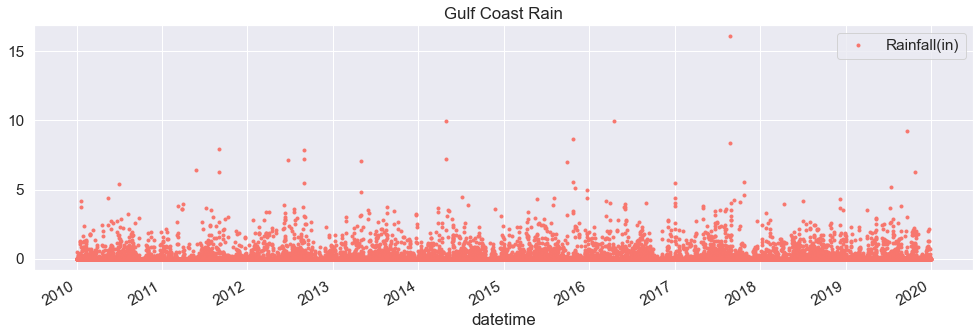

In [767]:
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
ragp.plot(style='.', figsize=(15,5), color=color_pal[0], title='Gulf Coast Rain')
plt.show()

In [768]:
#create time series features to see how the trends are impacted by day, week, quarter, month, year
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['day'] = df['date'].apply(pd.to_datetime).dt.dayofweek
    df['quarter'] = df['date'].apply(pd.to_datetime).dt.quarter
    df['month'] = df['date'].apply(pd.to_datetime).dt.month
    df['year'] = df['date'].apply(pd.to_datetime).dt.year
    df['dayYear'] = df['date'].apply(pd.to_datetime).dt.dayofyear
    df['dayMonth'] = df['date'].apply(pd.to_datetime).dt.day
    df['weekYear'] = df['date'].apply(pd.to_datetime).dt.weekofyear
    
    X = df[['day','quarter','month','year',
           'dayYear','dayMonth','weekYear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(ragp, label='Rainfall(in)')

features_and_target = pd.concat([X, y], axis=1)

features_and_target.head()

,day,quarter,month,year,dayYear,dayMonth,weekYear,Rainfall(in)
datetime,,,,,,,,
2010-01-01,4,1,1,2010,1,1,53,0.0
2010-01-02,5,1,1,2010,2,2,53,0.0
2010-01-03,6,1,1,2010,3,3,53,0.0
2010-01-04,0,1,1,2010,4,4,1,0.0
2010-01-05,1,1,1,2010,5,5,1,0.0


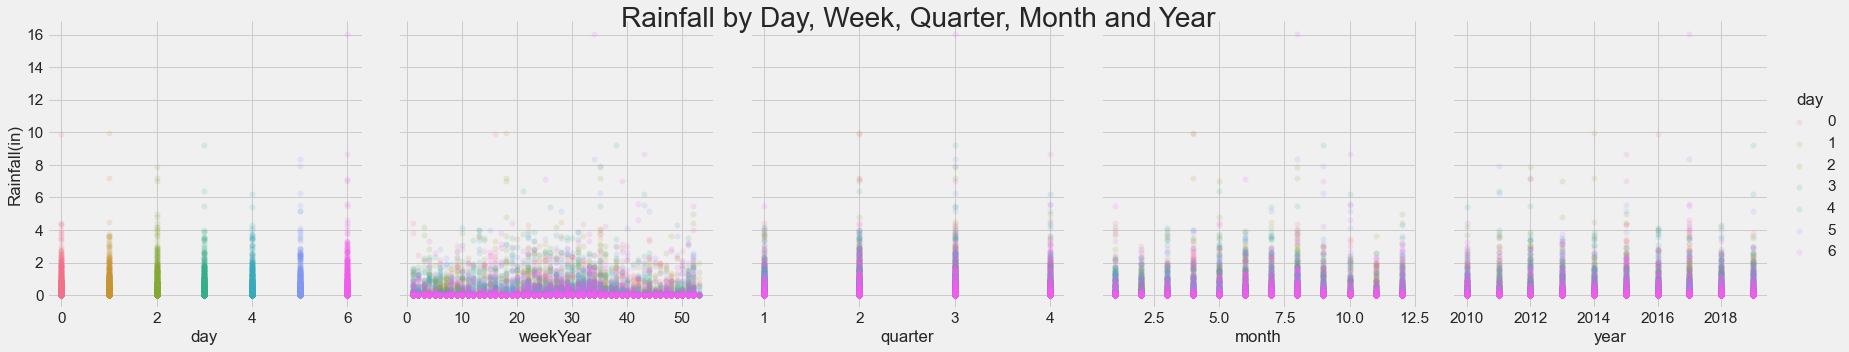

In [1092]:
#plotting features to see trends
#Rainfall has strong monthly properties
plt.rcParams['figure.figsize']=(30,15)
sns.pairplot(features_and_target.dropna(),
             hue='day',
             x_vars=['day', 'weekYear','quarter', 'month',
                     'year'],
             y_vars='Rainfall(in)',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Rainfall by Day, Week, Quarter, Month and Year', fontsize=28)
plt.show()

### Create the input data for Prophet

We'll be using our dataset that we already cleaning in our data wrangling section. We still need to manipulate it a bit to work with Prophet.

In [856]:
#prepare our dataset for Prophet timeseries
df = df_read.copy()

#Convert string datetime into readable datetime object
df['datetime'] = pd.to_datetime(df['datetime'])

#create dataframe with columns that we'll be using
df = df[['datetime','Dewpoint_temp(°F)','Humidity(%)','Sealevel_pressure(Hg)','Max_temp(°F)','Min_temp(°F)',
           'Average_temp(°F)', 'Wind_speed(mph)','Rainfall(in)']]

#set index to datetime
df.set_index('datetime', inplace=True)

print(df.shape)

(18243, 8)


In [858]:
#remove outliers about 5.5 inches of rain 
df= df[df['Rainfall(in)'] < 5.5]
df.shape

(18225, 8)

In [859]:
#create input features and target variable
#drop feature
X= df.drop('Rainfall(in)', axis=1)

#include features
y= df['Rainfall(in)']

In [860]:
#importances of our values in correlation to their impact on rainfall
importances= X.apply(lambda x: x.corr(y))
indices= np.argsort(importances)
print(importances[indices])

Sealevel_pressure(Hg)   -0.194383
Max_temp(°F)             0.007984
Average_temp(°F)         0.064095
Min_temp(°F)             0.109440
Dewpoint_temp(°F)        0.159427
Wind_speed(mph)          0.326622
Humidity(%)              0.331100
dtype: float64


***As we can see, wind speed and humidity have the biggest correlation with rainfall.***

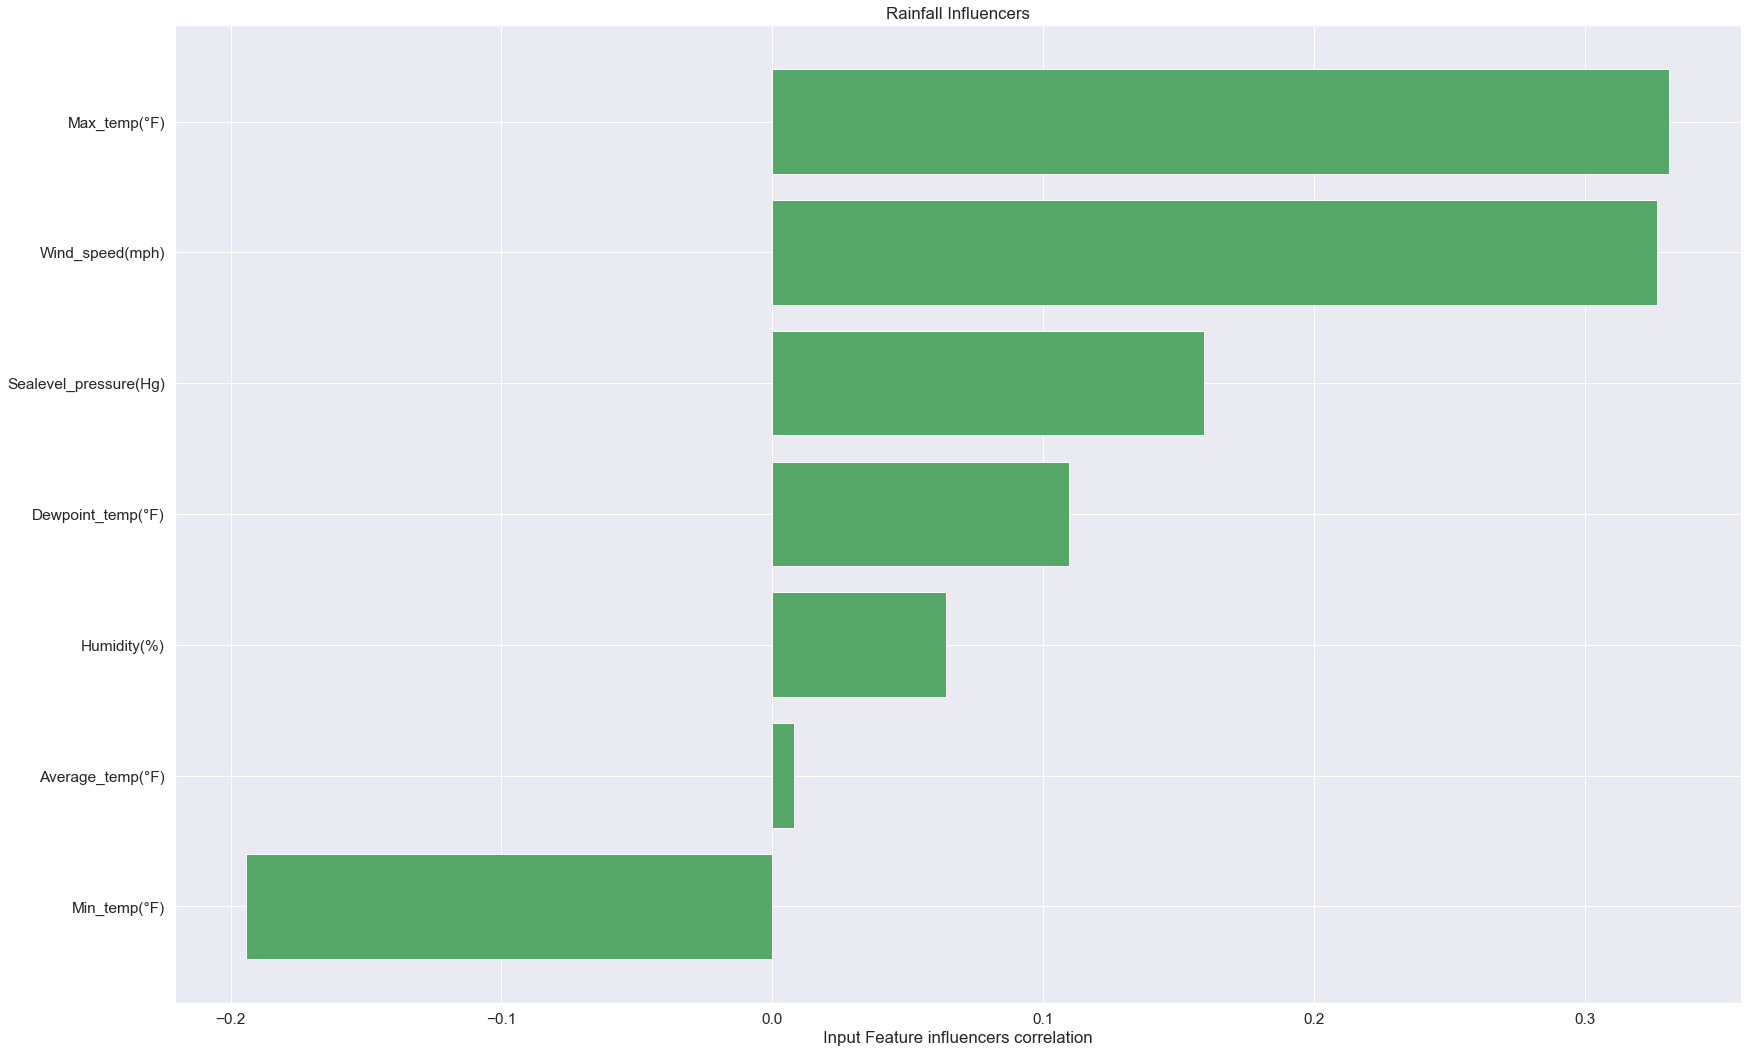

In [861]:
names=['Sealevel_pressure(Hg)', 'Max_temp(°F)', 'Min_temp(°F)', 'Average_temp(°F)',
       'Dewpoint_temp(°F)', 'Humidity(%)', 'Wind_speed(mph)', 'type']
plt.title('Rainfall Influencers')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [names[i] for i in indices])
plt.xlabel('Input Feature influencers correlation')
plt.show()

In [1077]:
df1 = df_read.copy()
df1= df1[df1['Rainfall(in)'] < 5.5]

#create input features and target variable from dataset with datetime
#drop feature
X= df1.drop('Rainfall(in)', axis=1)

#include features
y= df1['Rainfall(in)']

In [1078]:
#create dataframe with ds(datestamp) and y(predicted numeric column)
train_dataset= pd.DataFrame()
train_dataset['ds'] = pd.to_datetime(X["datetime"])
train_dataset['y']=y
train_dataset.head(2)

,ds,y
0,2010-01-01,0.0
1,2010-01-02,0.0


In [1079]:
#create and fit model with default values
# set the uncertainty interval to 95% (the Prophet default is 80%)
prophet_basic = Prophet(interval_width=0.95)

#fit model
prophet_basic.fit(train_dataset)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [1080]:
#predict values for the future
future= prophet_basic.make_future_dataframe(periods=731)
future.tail(5)

,ds
18951,2021-12-27
18952,2021-12-28
18953,2021-12-29
18954,2021-12-30
18955,2021-12-31


***We set our future at 2 years(730 days) past our original dataset. Our future contains 18973 and will predict into the future (2021-12-31)***

In [870]:
#create forecast of future
forecast=prophet_basic.predict(future)

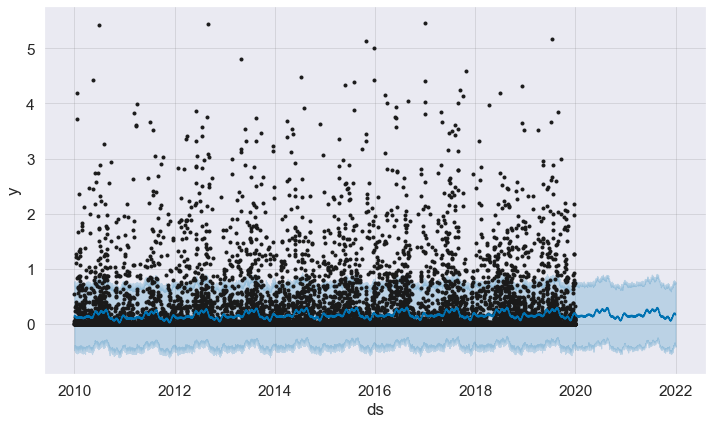

In [871]:
#plot predicted data
fig1 =prophet_basic.plot(forecast)

***The blue lines represent the forecasted values and the uncertainty intervals of the forecasts are the blue shaded regions.***

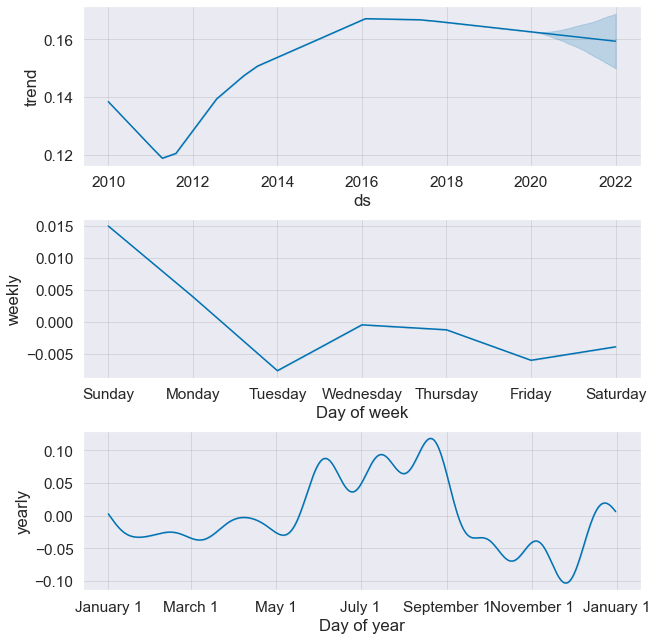

In [872]:
#plot the forecasted components
fig1 = prophet_basic.plot_components(forecast)

***The first plot shows that the monthly volume of rainfall dropped in 2011 but steadily increased until 2016 when it started to decrease slightly each year.***

***The second plot shows a mostly decrease in weekly trends. Day of the week isn't commonly a factor in weather though.***

***Our final plot is interesting because traditionally weather is affected by seasonal habits. As we can see in our plot, the warmer months of May-September were higher than the rest of the year but there were dips within those months.***

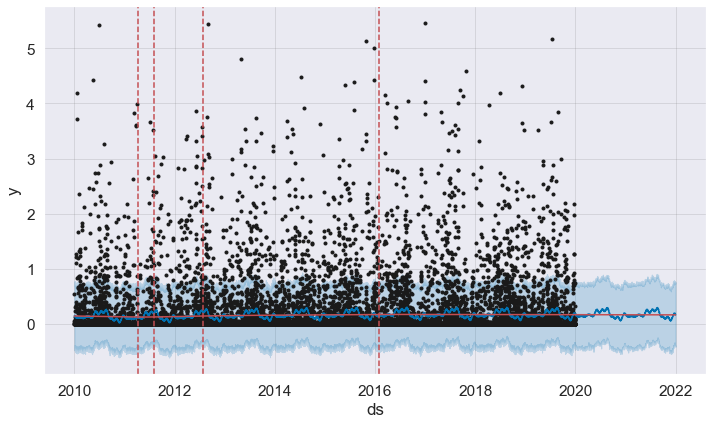

In [873]:
#Prophet detects changepoints by first specifying a large number of potential ChangePoints at which the rate is allowed to change
fig = prophet_basic.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet_basic, forecast)

In [874]:
#view the dates where the ChangePoints occurred
prophet_basic.changepoints

583     2010-04-27
1166    2010-08-22
1749    2010-12-16
2333    2011-04-12
2916    2011-08-07
3499    2011-12-02
4082    2012-03-29
4665    2012-07-24
5248    2012-11-18
5832    2013-03-14
6415    2013-07-09
6998    2013-11-03
7581    2014-03-01
8164    2014-06-26
8747    2014-10-20
9331    2015-02-15
9914    2015-06-12
10497   2015-10-06
11080   2016-01-31
11663   2016-05-27
12246   2016-09-21
12830   2017-01-16
13413   2017-05-12
13996   2017-09-06
14579   2018-01-01
Name: ds, dtype: datetime64[ns]

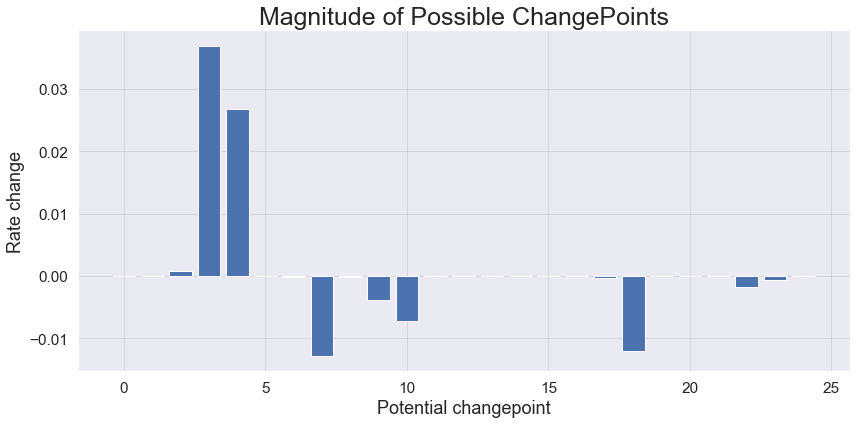

In [875]:
#look at the magnitudes of these possible changepoints
deltas = prophet_basic.params['delta'].mean(0)
fig = plt.figure(figsize=(12,6),facecolor='w')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_title('Magnitude of Possible ChangePoints', fontsize=25)
ax.set_ylabel('Rate change', fontsize=18)
ax.set_xlabel('Potential changepoint', fontsize=18)
fig.tight_layout()

### Ajusting Trend

By default the scale is set to 0.05 so we'll adjust the trend to be more flexible by increasing the value and then by decreasing the value.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


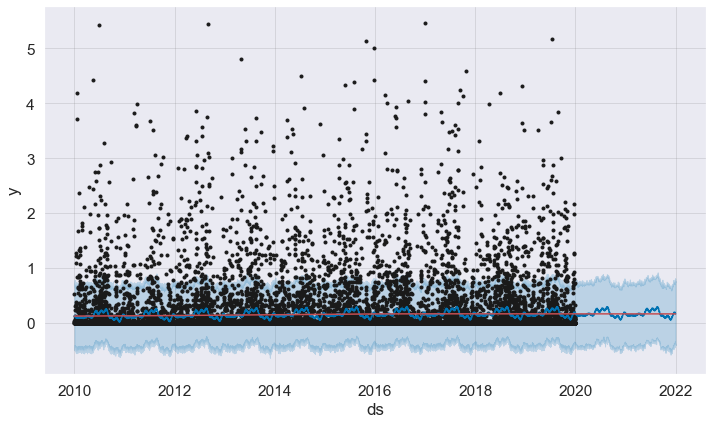

In [876]:
#decrease the ChangePoint prior scale
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.02)
forecast = pro_change.fit(train_dataset).predict(future)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


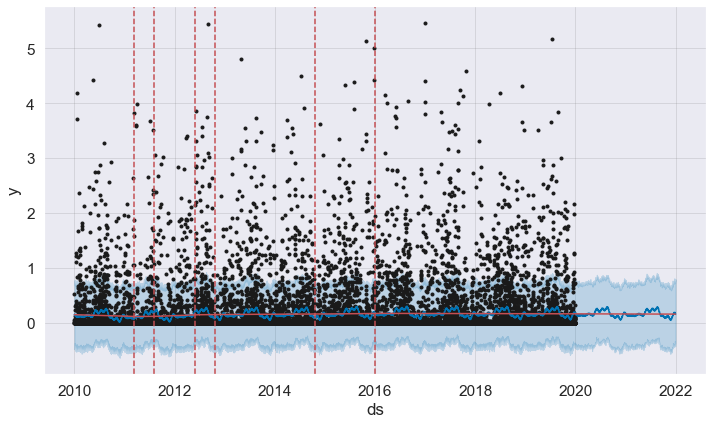

In [877]:
#increase the ChangePoint prior scale
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.08)
forecast = pro_change.fit(train_dataset).predict(future)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

In [879]:
#view the dates where the ChangePoints occurred
pro_change.changepoints

729     2010-05-26
1458    2010-10-19
2187    2011-03-14
2916    2011-08-07
3645    2012-01-01
4374    2012-05-26
5103    2012-10-20
5832    2013-03-14
6561    2013-08-08
7290    2014-01-01
8018    2014-05-27
8747    2014-10-20
9476    2015-03-16
10205   2015-08-09
10934   2016-01-02
11663   2016-05-27
12392   2016-10-20
13121   2017-03-15
13850   2017-08-08
14579   2018-01-01
Name: ds, dtype: datetime64[ns]

***Our graphs did a good job of predicting a base amount of rainfall for the next 2 years. We can fine tune it a bit more to get more precise blue lines and blue shaded area.***

## Simple Linear Regression

In [201]:
#create our dataframe for Linear Regression starting with our cleaned dataset
df_lr = df_read.copy()

#we know that our outliers are mainly found above 6 inches of rain so we'll remove them from our dataset
df_lr= df_lr[df_lr['Rainfall(in)'] < 6]

(18230, 10)

In [961]:
df_lr.describe()

,Dewpoint_temp(°F),Humidity(%),Sealevel_pressure(Hg),Max_temp(°F),Min_temp(°F),Average_temp(°F),Wind_speed(mph),Rainfall(in)
count,18219.000000,18219.000000,18219.000000,18219.000000,18219.000000,18219.000000,18219.000000,18219.000000
mean,60.486150,73.605187,30.049438,79.981338,61.396125,70.939623,22.747022,0.150491
std,13.938184,11.385460,0.140188,12.205966,14.036088,12.753573,6.913487,0.446843
min,4.708333,21.000000,29.440000,31.000000,16.000000,26.000000,0.000000,0.000000
25%,52.000000,67.000000,29.960000,72.000000,51.000000,62.000000,18.000000,0.000000
50%,64.384615,75.000000,30.036250,82.000000,65.000000,74.000000,22.000000,0.000000
75%,72.000000,82.000000,30.130000,90.000000,74.000000,82.000000,26.000000,0.030000
max,80.000000,100.000000,30.695417,109.000000,85.000000,95.000000,120.000000,4.810000


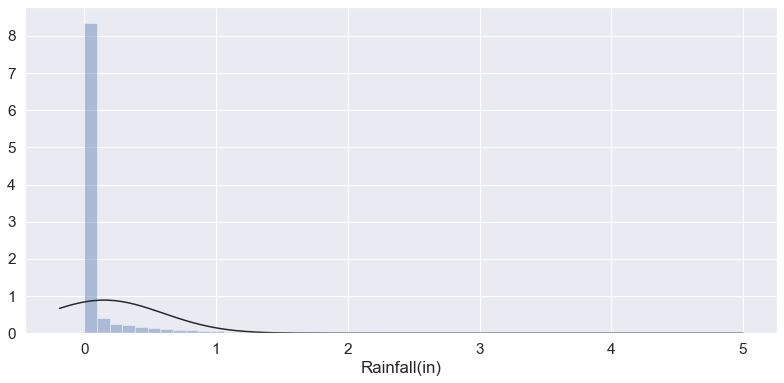

In [943]:
#plot our Rainfall value
plt.figure(figsize=(12,6))
plt.tight_layout()
seabornInstance.distplot(df_lr['Rainfall(in)'],fit=norm, kde=False)

***We can see that a majority of our days consisted of zero rainfall with amounts under 1" having a strong showing as well. Average looks to be around 0.01-0.02 inches***

In [924]:
#divide dataframe into independent variables(X) and dependent variables(y)
X = df_lr['Humidity(%)'].values.reshape(-1,1)
y = df_lr['Rainfall(in)'].values.reshape(-1,1)

In [925]:
#split 70% of our dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [926]:
#train our algorithm
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [927]:
#To retrieve the intercept:
print(regressor.intercept_)

#For retrieving the slope:
print(regressor.coef_)

[-0.81218075]
[[0.01306654]]


***We can see that for every one unit of change in Dewpoint temps, there is a minimal change in Rainfall.***

In [890]:
#make predictions with our test data
y_pred = regressor.predict(X_test)

In [891]:
#compare the actual output values with the predicted values
dl = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
dl

,Actual,Predicted
0,0.01,0.103252
1,0.00,0.029374
2,0.00,0.187538
3,0.69,0.213049
4,0.49,0.202844
...,...,...
5461,0.00,0.087410
5462,0.00,0.197742
5463,0.00,0.126313
5464,0.00,0.111385


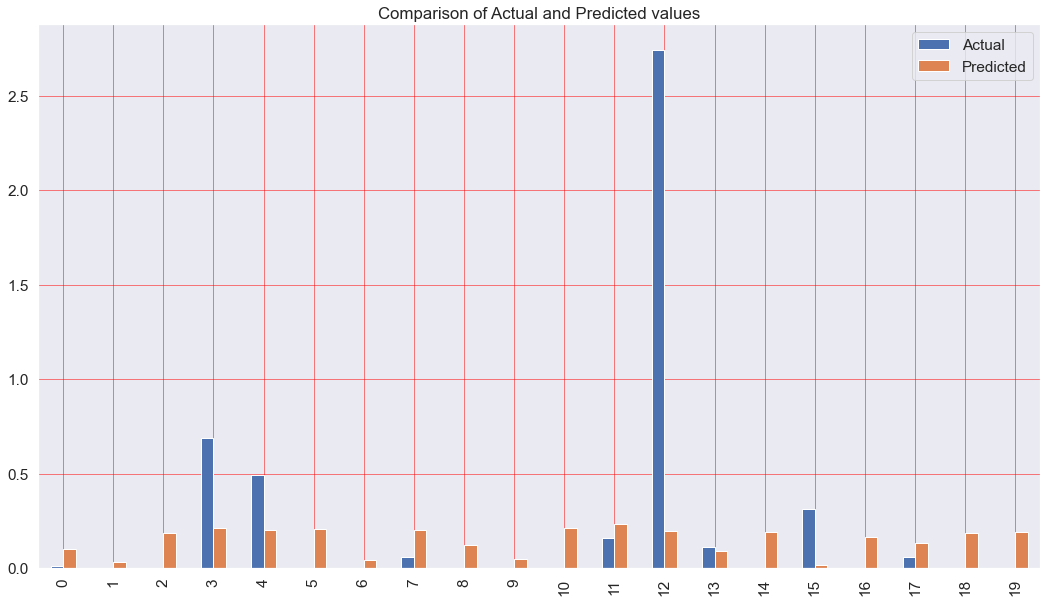

In [892]:
#we'll take a look at the 1st 20 records
dl1 = dl.head(20)
dl1.plot(kind='bar',figsize=(14,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='red')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title('Comparison of Actual and Predicted values')
plt.show()

***We can see that our predicted precentages aren't close to our actual ones***

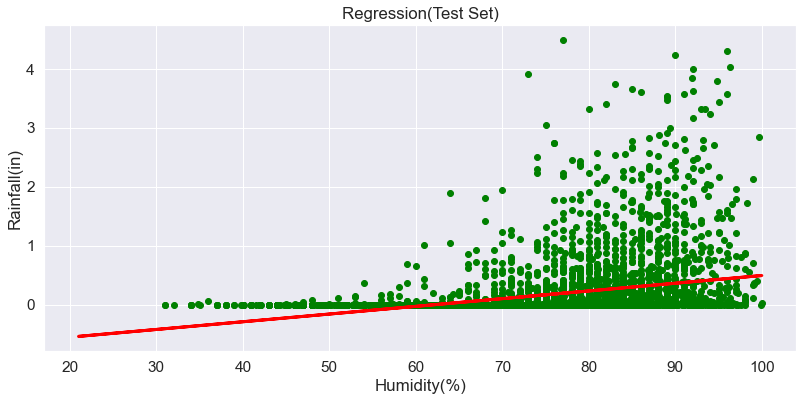

In [948]:
#plot straight line with the test data
plt.figure(figsize=(12,6))
plt.scatter(X_test,y_test,color="green") # Plot a graph with X_test vs y_test
plt.plot(X_train,regressor.predict(X_train),color="red",linewidth=3) # Regressior line showing
plt.title('Regression(Test Set)')
plt.xlabel('Humidity(%)')
plt.ylabel('Rainfall(in)')
plt.show()

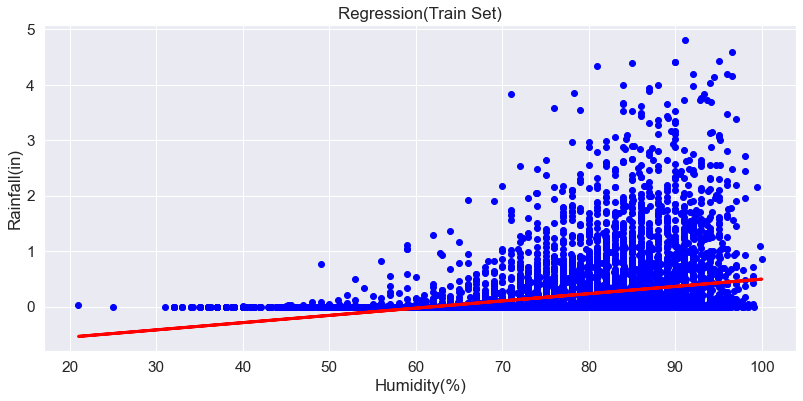

In [949]:
#plot straight line with the train data
plt.figure(figsize=(12,6))
plt.scatter(X_train,y_train,color="blue")  # Plot a graph with X_train vs y_train
plt.plot(X_train,regressor.predict(X_train),color="red",linewidth=3) # Regressior line showing
plt.title('Regression(Train Set)')
plt.xlabel('Humidity(%)')
plt.ylabel('Rainfall(in)')
plt.show()

In [947]:
#print mean absolute error, mean square error and root mean squared error
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 score: %.2f' % r2_score(y_test,y_pred))

Mean Absolute Error: 0.2291924509860805
Mean Squared Error: 0.18231502321324472
Root Mean Squared Error: 0.42698363342550344
R2 score: 0.11


***We can see that the value of the root mean squared error is 0.4269 which is more than 10% of the mean value of 73.605187. It can be better but still can make good predictions.***

## Multiple Linear Regression

In the last section we used a simple linear regression that left off most of our dataset. Here we'll included the other variables and hopefully get better results.

In [251]:
#we'll use the same dataframe as before
df_lr.describe()

,Dewpoint_temp(°F),Humidity(%),Sealevel_pressure(Hg),Max_temp(°F),Min_temp(°F),Average_temp(°F),Wind_speed(mph),Rainfall(in)
count,18230.000000,18230.000000,18230.000000,18230.000000,18230.000000,18230.000000,18230.000000,18230.000000
mean,60.492364,73.616037,30.049334,79.981295,61.400713,70.941909,22.754580,0.153783
std,13.936569,11.390998,0.140245,12.202712,14.033583,12.750438,6.923023,0.466505
min,4.708333,21.000000,29.440000,31.000000,16.000000,26.000000,0.000000,0.000000
25%,52.000000,67.000000,29.960000,72.000000,51.000000,62.000000,18.000000,0.000000
50%,64.434874,75.000000,30.036042,82.000000,65.000000,74.000000,22.000000,0.000000
75%,72.000000,82.000000,30.130000,90.000000,74.000000,82.000000,26.000000,0.030000
max,80.000000,100.000000,30.695417,109.000000,85.000000,95.000000,120.000000,6.410000


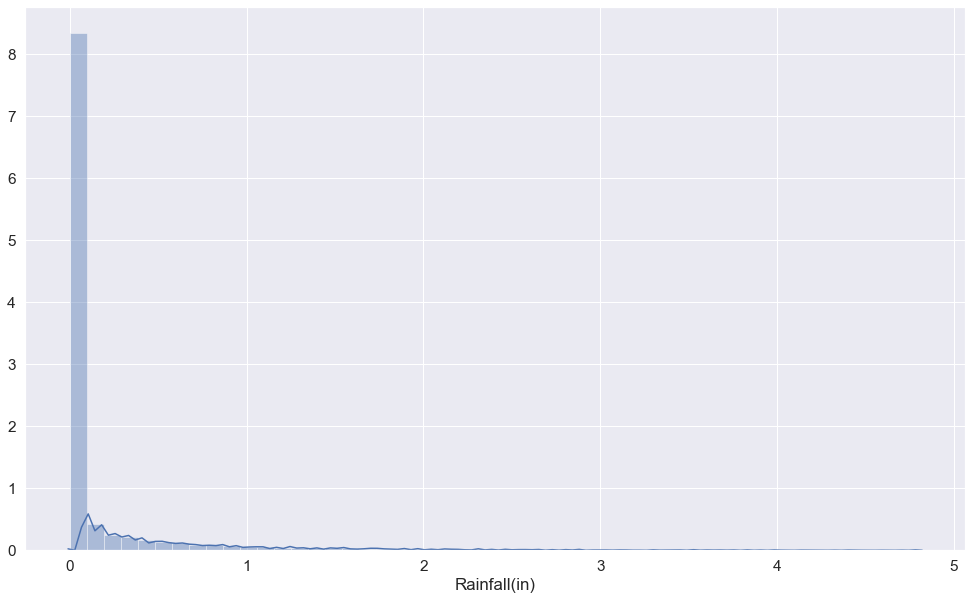

In [895]:
plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(df_lr['Rainfall(in)'])

In [952]:
#divide dataframe into independent variables(X) and dependent variables(y)
X = df_lr[['Dewpoint_temp(°F)', 'Humidity(%)', 'Sealevel_pressure(Hg)', 'Max_temp(°F)', 'Min_temp(°F)', 'Average_temp(°F)',
        'Wind_speed(mph)']]
y = df_lr['Rainfall(in)']

In [953]:
#split 70 of our dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [954]:
#train our model
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [955]:
#create dataframe of our features and their importances to dependent varaible(Rainfall)
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])  

coeff_df

,Coefficient
Dewpoint_temp(°F),-0.017320
Humidity(%),0.018396
Sealevel_pressure(Hg),-0.220356
Max_temp(°F),0.001950
Min_temp(°F),0.012248
Average_temp(°F),0.000294
Wind_speed(mph),0.018702


***For a unit incrase in Dewpoint temps, there is a decrease of -0.017 of Rainfall. A unit of decrease in Sealevel Pressure results a decrease of -0.22 ***

In [956]:
#predict test data
y_pred = regressor.predict(X_test)

In [957]:
#difference between actual value and predicted value
dlf = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
dlf1 = dlf.head(25)
dlf1

,Actual,Predicted
5205,0.01,0.084850
15437,0.00,-0.185270
7440,0.00,0.209444
2334,0.69,0.613966
11095,0.49,0.105025
9640,0.00,0.135486
6885,0.00,-0.057241
6984,0.06,0.562212
5083,0.00,0.307639
5150,0.00,0.463022


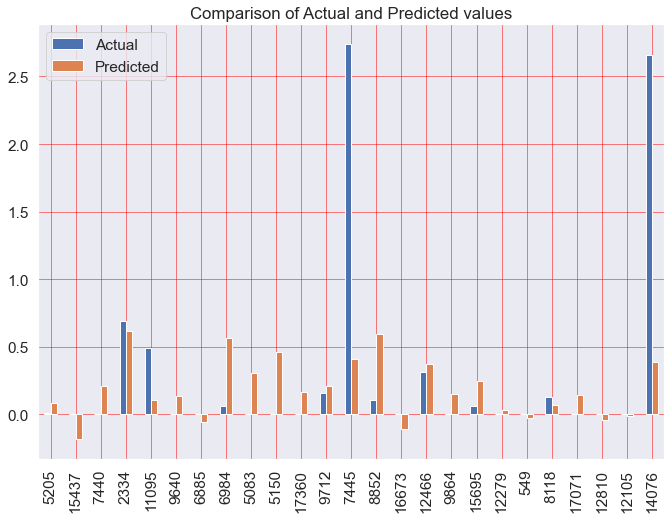

In [958]:
#plot camparison of Actual and Predicted values
dlf1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='red')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title('Comparison of Actual and Predicted values')
plt.show()

***Our prediction model is not very precise. The predicted percentages are close to the actual on a few occassions but far off on others***

In [959]:
#print mean absolute error, mean square error and root mean squared error
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 score: %.2f' % r2_score(y_test,y_pred))

Mean Absolute Error: 0.2172496596267762
Mean Squared Error: 0.16018005793003015
Root Mean Squared Error: 0.4002250091261541
R2 score: 0.22


***Root mean square error is 0.40 which is higher than the Rainfall mean value.***


***There are many factors that could contribute to our inaccuracy. We could use more data features to see if there are any other factors that have a more positive co-efficiency with predicting rainfall.***

## XGBoost

In [978]:
import xgboost

# drop inconsequential features
X = df_lr[['Dewpoint_temp(°F)', 'Humidity(%)', 'Sealevel_pressure(Hg)', 'Max_temp(°F)', 'Min_temp(°F)', 'Average_temp(°F)',
        'Wind_speed(mph)']]
y = df_lr['Rainfall(in)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

model = xgboost.XGBRegressor(objective ='reg:squarederror', max_depth = 3, learning_rate = 0.05) 
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [979]:
#split 70 of our dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 23)

model = xgboost.XGBRegressor(objective ='reg:squarederror', max_depth = 3, learning_rate = 0.05) 

model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [665]:
#
parameters_for_testing = {
    'min_child_weight':[1,2,3],
    'learning_rate':[0.1,0.07,0.05],
    'max_depth':[3,5],
}

                    
xgb_model = xgboost.XGBRegressor(objective = 'reg:squarederror', learning_rate =0.1, n_estimators=1000, max_depth=5,
     min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=15)

gsearch1 = GridSearchCV(cv = 5, estimator = xgb_model, param_grid = parameters_for_testing, 
                        n_jobs=6,iid=False, verbose=10,scoring='r2')
gsearch1.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   45.6s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   46.0s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:  4.5min
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:  6.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=1,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=1000, n...
                                    objective='reg:squarederror',
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=1,
                                    seed=15, subsample=0.8, tree_method=None,
   

In [666]:
print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)

best params
{'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 2}
best score
0.2860044021771449


In [980]:
xgb_feature_importances = pd.DataFrame({'feature': X.columns,
                                        'importance': model.feature_importances_}).sort_values('importance',
                                                                                               ascending=False)
xgb_feature_importances.head(10)

,feature,importance
1,Humidity(%),0.402190
6,Wind_speed(mph),0.253238
2,Sealevel_pressure(Hg),0.096502
0,Dewpoint_temp(°F),0.089595
4,Min_temp(°F),0.067115
3,Max_temp(°F),0.052168
5,Average_temp(°F),0.039192


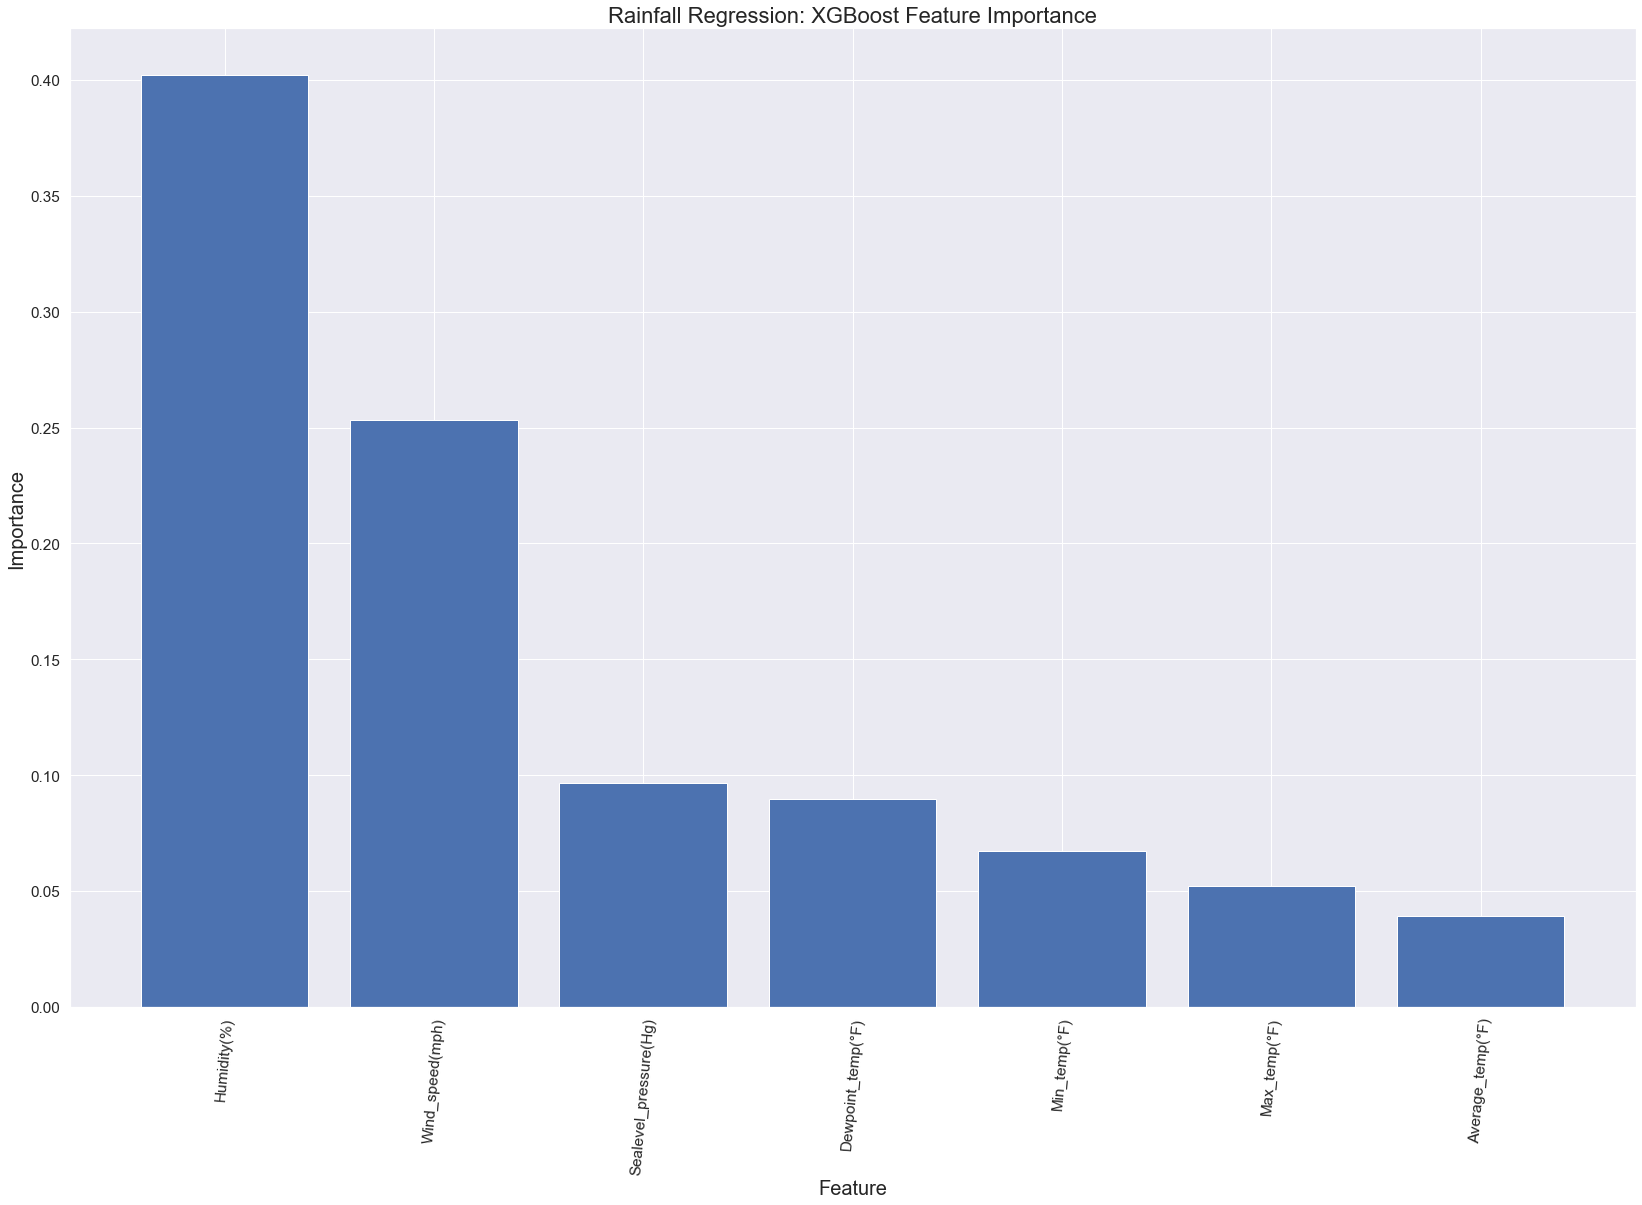

In [981]:
plt.bar(xgb_feature_importances.feature[:10], xgb_feature_importances.importance[:10])
plt.xlabel('Feature', fontsize=20)
plt.ylabel('Importance', fontsize= 20)
plt.xticks(xgb_feature_importances.feature[:10], rotation = 85)
plt.title('Rainfall Regression: XGBoost Feature Importance', fontsize=22)
plt.show()

In [982]:
#predict model
model.predict(X_test)

#model test score
xgb_rsq = model.score(X_test, y_test)
print('Test score:', xgb_rsq)

#model train score
xgb_rss = model.score(X_train, y_train)
print('Train score:', xgb_rss)

Test score: 0.28403937909088106
Train score: 0.3822221311483073


***Our test and training scores means our model isn't too overfit.***

***Our feature importance seem to keep in line with our other models and correlation heatmaps with rainfall. Humidity has usually been at or near the top. Dewpoint seems to be a bit lower than usual.***

***Our score is a bit low. We could add other outside features to see if it would increase our score.***

## Random Forest Regression

In [1069]:
#using the same dataset as with our other models

# drop inconsequential features
X = df_lr[['Dewpoint_temp(°F)', 'Humidity(%)', 'Sealevel_pressure(Hg)', 'Max_temp(°F)', 'Min_temp(°F)', 'Average_temp(°F)',
        'Wind_speed(mph)']]
y = df_lr['Rainfall(in)']

#split 70 of our dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# create regressor object
rf = RandomForestRegressor(n_estimators=100, random_state=23)

# fit the regressor with x and y data
rf.fit(X_train, y_train)

#predict our model
y_pred = rf.predict(X_test)

#test score of our model
rf_rsq = rf.score(X_test, y_test)

print('Model R-squared:', round(rf_rsq, 3))

Model R-squared: 0.257


In [1070]:
rf_feat_df = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_}
             ).sort_values('importance', ascending=False)
rf_feat_df['rank'] = range(1,len(rf_feat_df)+1)
rf_feat_df.head(10)

,feature,importance,rank
1,Humidity(%),0.284221,1
6,Wind_speed(mph),0.216116,2
2,Sealevel_pressure(Hg),0.143396,3
0,Dewpoint_temp(°F),0.105480,4
4,Min_temp(°F),0.093571,5
3,Max_temp(°F),0.091682,6
5,Average_temp(°F),0.065534,7


***The order of our features are in the same order as before but their importance have dropped slightly***

In [1071]:
clf = RandomForestRegressor(n_estimators=100)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.2624685029903844

In [1072]:
print('Training Features Shape:', X_test.shape)
print('Training Labels Shape:', y_test.shape)
print('Testing Features Shape:', X_train.shape)
print('Testing Labels Shape:', y_train.shape)

Training Features Shape: (3644, 7)
Training Labels Shape: (3644,)
Testing Features Shape: (14575, 7)
Testing Labels Shape: (14575,)


In [1073]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train);

In [1038]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = 
train_test_split(features, labels, test_size = 0.25, random_state = 42)

SyntaxError: invalid syntax (<ipython-input-1038-8d567a220400>, line 2)

In [ ]:
X_train, X_test, y_train, y_test =
train_test_split(X, y, test_size=0.2, random_state=23)

In [1039]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.16 degrees.


***Our average estimate is off by 0.16 degrees which is under the baseline.***

In [1074]:
#create list of X columns
feature_list = list(X.columns)

# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Humidity(%)          Importance: 0.28
Variable: Wind_speed(mph)      Importance: 0.22
Variable: Sealevel_pressure(Hg) Importance: 0.14
Variable: Dewpoint_temp(°F)    Importance: 0.11
Variable: Max_temp(°F)         Importance: 0.09
Variable: Min_temp(°F)         Importance: 0.09
Variable: Average_temp(°F)     Importance: 0.07


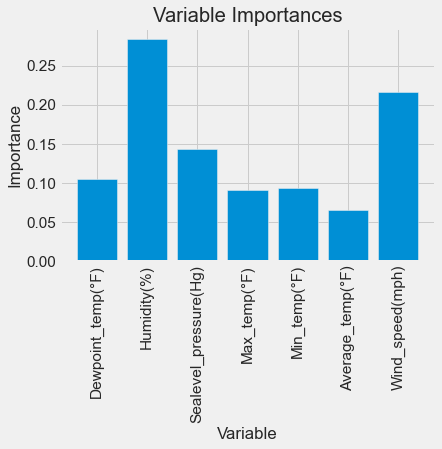

In [1075]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

***Bar plot of the feature importances to show the disparities in the relative significance of the variables. As mentioned before Humidity and Windspeed show the highest importance levels***

In [1076]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: -inf %.


In [1068]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Extract the two most important features
important_indices = [feature_list.index('Humidity(%)'), feature_list.index('Wind_speed(mph)')]
train_important = X_train.iloc[:, important_indices]
test_important = X_test.iloc[:, important_indices]

# Train the random forest
rf_most_important.fit(train_important, y_train)

# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - y_test)

# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
mape = np.mean(100 * (errors / y_test))
accuracy = 100 - mape

print('Accuracy:', round(accuracy, 2), '%.')

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [1063]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [1064]:
regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [1065]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.16317768935236004
Mean Squared Error: 0.140442341863337
Root Mean Squared Error: 0.37475637668135414


# Scratch Notebook

In [21]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [22]:
df = pd.read_csv('df_clean.csv')

In [23]:
df1= df_rain_out.copy()

In [24]:
#Convert string DATE into readable datetime object
df1['datetime'] = pd.to_datetime(df1['datetime'])

In [25]:
df1['datetime'].min(), df1['datetime'].max()

(Timestamp('2010-01-01 00:00:00'), Timestamp('2019-12-31 00:00:00'))

In [26]:
df1.sort_values('Rainfall(in)')

,City,datetime,Rainfall(in)
0,Houston,2010-01-01,0.00
11062,Pascagoula,2010-04-28,0.00
11063,Pascagoula,2010-04-29,0.00
11065,Pascagoula,2010-05-01,0.00
11069,Pascagoula,2010-05-05,0.00
...,...,...,...
2119,Houston,2015-10-24,5.54
13793,Pascagoula,2017-10-22,5.58
10877,New_Orleans,2019-10-25,6.24
7906,New_Orleans,2011-09-03,6.25


In [27]:
df1 = df1.set_index('datetime')
df1.index

DatetimeIndex(['2010-01-01', '2010-01-02', '2010-01-03', '2010-01-04',
               '2010-01-05', '2010-01-06', '2010-01-07', '2010-01-08',
               '2010-01-09', '2010-01-10',
               ...
               '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
               '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='datetime', length=18230, freq=None)

In [28]:
y1 = df1['Rainfall(in)'].resample('MS').mean()

In [29]:
df1.drop('City', axis=1, inplace=True)
df1

,Rainfall(in)
datetime,
2010-01-01,0.00
2010-01-02,0.00
2010-01-03,0.00
2010-01-04,0.00
2010-01-05,0.00
...,...
2019-12-27,0.00
2019-12-28,0.32
2019-12-29,0.07


In [30]:
y1['2017':]

datetime
2017-01-01    0.231871
2017-02-01    0.082714
2017-03-01    0.086968
2017-04-01    0.135133
2017-05-01    0.202452
2017-06-01    0.367867
2017-07-01    0.214323
2017-08-01    0.410392
2017-09-01    0.075600
2017-10-01    0.202968
2017-11-01    0.011533
2017-12-01    0.092452
2018-01-01    0.122516
2018-02-01    0.167286
2018-03-01    0.081871
2018-04-01    0.110933
2018-05-01    0.163871
2018-06-01    0.187000
2018-07-01    0.200194
2018-08-01    0.305871
2018-09-01    0.262867
2018-10-01    0.126129
2018-11-01    0.139933
2018-12-01    0.258323
2019-01-01    0.126645
2019-02-01    0.112571
2019-03-01    0.046000
2019-04-01    0.147133
2019-05-01    0.185871
2019-06-01    0.223800
2019-07-01    0.266065
2019-08-01    0.222645
2019-09-01    0.073154
2019-10-01    0.285161
2019-11-01    0.030533
2019-12-01    0.111484
Freq: MS, Name: Rainfall(in), dtype: float64

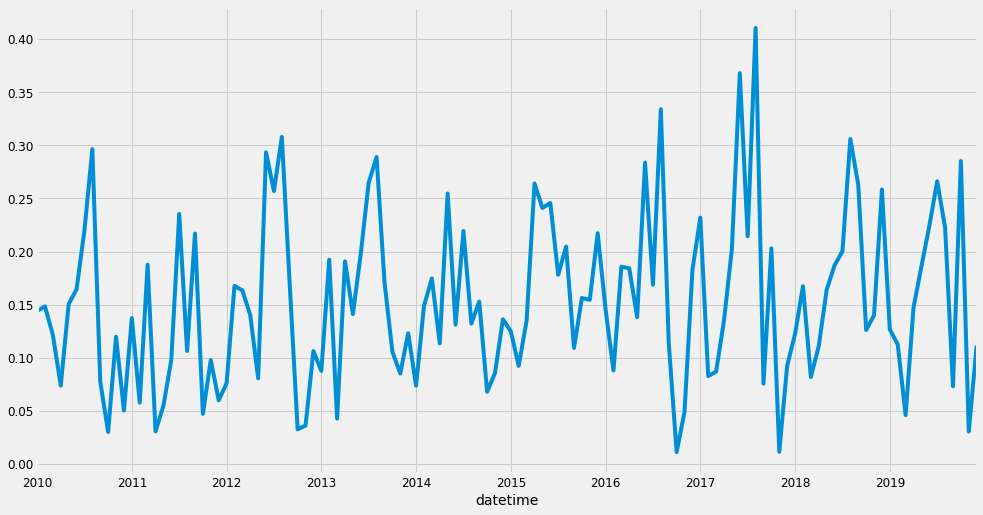

In [31]:
y1.plot(figsize=(15,8))
plt.show()

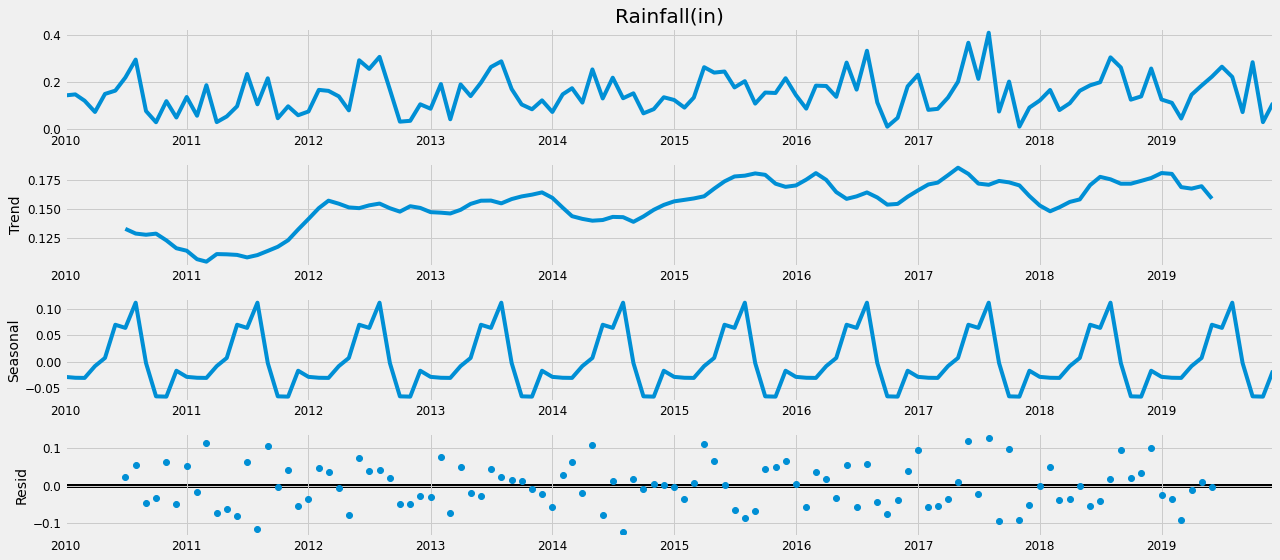

In [32]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y1, model='additive')
fig = decomposition.plot()
plt.show()

In [33]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [34]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:25815.506051400276
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:25647.39701113692
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:36459.82109028922
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:23997.509152298473
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:25621.132362623277
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:24010.868335422594
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:31317.193959470576
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:23999.509042551686
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:24963.035679406472
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:24878.48849414943
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:36144.77130679574
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:23609.67259967236
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:24869.4561815594
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:23623.070855748283
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:30984.53172703618
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:23611.67286103923
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:33609.13212245417
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:33597.599270438055
AR

In [35]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1386      0.005     26.812      0.000       0.128       0.149
ma.L1         -1.0000      0.053    -18.834      0.000      -1.104      -0.896
ar.S.L12      -0.4967      0.003   -194.518      0.000      -0.502      -0.492
sigma2         0.3207      0.017     18.615      0.000       0.287       0.354


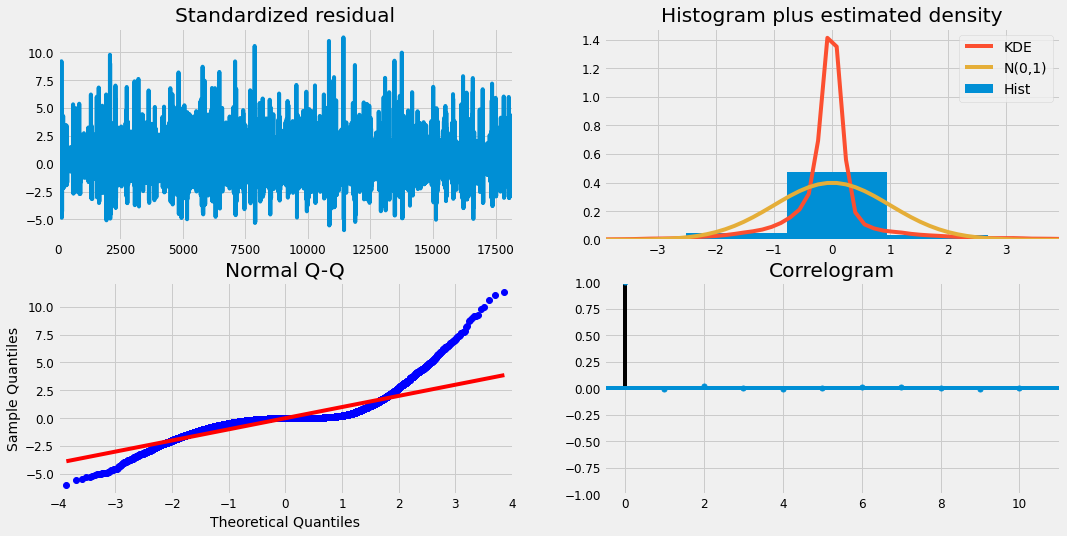

In [36]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Traceback (most recent call last):
  File "C:\Users\Jimsyd\Anaconda3\lib\site-packages\matplotlib\axis.py", line 1573, in convert_units
    ret = self.converter.convert(x, self.units, self)
  File "C:\Users\Jimsyd\Anaconda3\lib\site-packages\matplotlib\category.py", line 61, in convert
    unit.update(values)
  File "C:\Users\Jimsyd\Anaconda3\lib\site-packages\matplotlib\category.py", line 212, in update
    cbook._check_isinstance((str, bytes), value=val)
  File "C:\Users\Jimsyd\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 2128, in _check_isinstance
    type_name(type(v))))
TypeError: 'value' must be an instance of str or bytes, not a pandas._libs.tslibs.period.Period

The above exception was the direct cause of the following exception:

Traceback (most r

TypeError: index type not supported

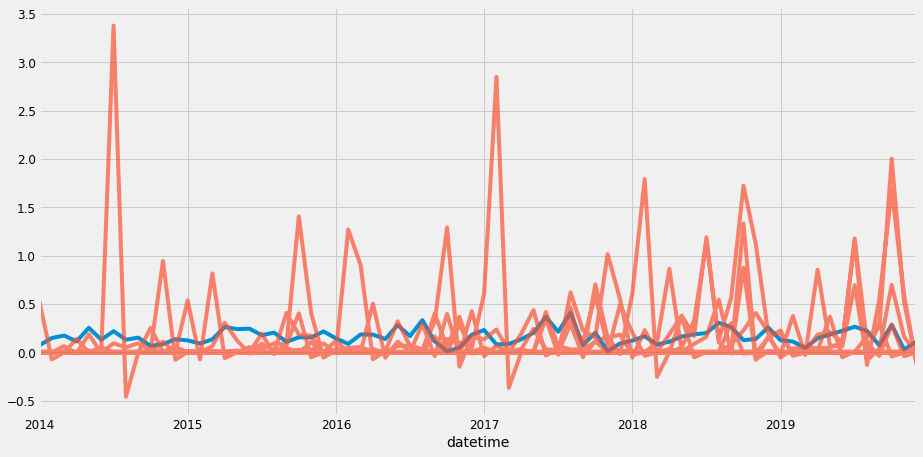

In [37]:
pred = results.get_prediction(start=('2010-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y1['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Rainfall(in)')
plt.legend()

plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = y1['2017-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [ ]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

In [ ]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = y1.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')

plt.legend()
plt.show()

In [ ]:
df2 = df.copy()
#create a new column to show rain(1) or no rain(0) days
df2['Rain or Not'] = np.where(df2['Rainfall(in)'] > 0, 1, 0)

df2

In [ ]:
#Convert string DATE into readable datetime object
df2['datetime'] = pd.to_datetime(df2['datetime'])

In [ ]:
rain = df['Rainfall(in)']
dew = df[''] == 0]

In [ ]:
rain = df2.loc[df2['Rain or Not'] == 1]
ew = df2.loc[df2['Rain or Not'] == 0]

In [ ]:
no_rain

In [ ]:
rain= df[['City', 'datetime', 'Rainfall(in)', 'Dewpoint_temp(°F)']]
dew = df[['City', 'datetime', 'Rainfall(in)', 'Dewpoint_temp(°F)']]

In [ ]:
rain.drop('City', axis=1, inplace=True)
dew.drop('City', axis=1, inplace=True)

rain= rain.sort_values('datetime')
dew = dew.sort_values('datetime')

In [ ]:
rain.shape, dew.shape

In [ ]:
dew

In [ ]:
rain = rain.set_index('datetime')
dew = dew.set_index('datetime')

y_rain = rain['Rainfall(in)'].resample('MS').mean()
y_dew = dew['Dewpoint_temp(°F)'].resample('MS').mean()

rain= pd.DataFrame({'datetime':y_rain.index, 'Rainfall(in)':y_rain.values})
dew= pd.DataFrame({'datetime':y_dew.index, 'Dew':y_dew.values})

In [ ]:
dew

In [ ]:
total = rain.merge(dew, how='inner', on='datetime')
#total.rename(columns={'Rain or Not_x': 'Rainfall', 'Rain or Not_y': 'No_Rainfall'}, inplace=True)
total.head()

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(total['datetime'], total['Rainfall(in)'], 'b-', label = 'Rainfall')
plt.plot(total['datetime'], total['Dew'], 'r-', label = 'Dew')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Furniture and Office Supplies')
plt.legend();

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [ ]:
df5 = df.copy()

In [ ]:
df5.head(3)

In [ ]:
e = df5.iloc[:,2:].head(5)
e

In [ ]:
creation = df5.iloc[:,2:]
labels=np.array(creation['Rainfall(in)'])
creation=creation.drop('Rainfall(in)',axis=1)
creation_list=list(creation.columns)
creation=np.array(creation)

In [ ]:
train_creation, test_creation, train_labels, test_labels= train_test_split(creation,labels, test_size=0.30,random_state=4)

In [38]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.externals import joblib
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
import csv
import datetime
from math import sqrt
from sklearn.svm import SVR
import sklearn.svm as svm
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


from collections import Counter
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, roc_curve,precision_recall_curve, precision_score, confusion_matrix, classification_report

In [ ]:
df_time = pd.get_dummies(df_time, drop_first=True)
df_time

In [ ]:
df_time = df.copy()
df_time['Day'] = df_time['datetime'].dt.day
df_time['Week'] = df_time['datetime'].dt.week
df_time['Month'] = df_time['datetime'].dt.month
df_time['Year'] = df_time['datetime'].dt.year

df_time.head()

In [ ]:
df_time.shape

In [ ]:
df = pd.read_csv('df_clean.csv')

In [ ]:
#Convert string DATE into readable datetime object
df['datetime'] = pd.to_datetime(df['datetime'])

In [ ]:
df_time

In [ ]:
#we see that the outliers are mainly found above 7 inches of rain so we'll remove them from our dataset
df_time = df_time[df_time['Rainfall(in)'] < 7]
df_time.shape

In [ ]:
df7 = df.copy()
df7

In [ ]:
df7.drop('City', axis=1, inplace=True)

In [ ]:
df7 = df7.set_index('datetime')
#rain = rain.set_index('datetime')
df7

In [ ]:
#we see that the outliers are mainly found above 7 inches of rain so we'll remove them from our dataset
df7 = df7[df7['Rainfall(in)'] < 7]
df7.shape

In [ ]:
y= df7['Rainfall(in)']
X= df7.drop('Rainfall(in)', axis=1)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)  # 70% training and 30% test

# create regressor object
rf = RandomForestRegressor(n_estimators=100, random_state=23)

# fit the regressor with x and y data
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rf_rsq = rf.score(X_test, y_test)

print('Model R-squared:', round(rf_rsq, 3))

In [ ]:
rf_feat_df = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_}
             ).sort_values('importance', ascending=False)
rf_feat_df['rank'] = range(1,len(rf_feat_df)+1)
rf_feat_df

In [ ]:
from sklearn.svm import SVR
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVR()))

In [39]:
df8 = df7.copy()

NameError: name 'df7' is not defined

In [ ]:
df8.head(2)

In [ ]:
df8['Day'] = df8['datetime'].dt.day
df8['Month'] = df8['datetime'].dt.month
df8['Year'] = df8['datetime'].dt.year

In [ ]:
X1 = df8.drop('Rain or Not', axis=1)
y1 = df8['Rain or Not']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=0)

In [ ]:
# list of models to try
models = []
#models.append(('KNN', KNeighborsRegressor()))
models.append(('LR', LinearRegression()))
models.append(('RF', RandomForestClassifier()))

In [ ]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# train test check
def train_test():
    names = []
    scores = []
    AUC=[]
    Log_loss=[]
    for name, model in tqdm(models):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_prob=model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds=roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        scores.append(accuracy_score(y_test, y_pred))
        AUC.append(roc_auc)
        names.append(name)
        Log_loss.append(round(log_loss(y_test, y_pred),4))
    tr_split = pd.DataFrame({'Name': names, 'Accuracy': scores,'AUC':AUC,'Log_loss':Log_loss})
    print(tr_split)

In [ ]:
def cross_val():
    names = []
    scores = []

    # cross val check
    for name, model in tqdm(models):
        kfold = KFold(n_splits=10, random_state=10) 
        score = cross_val_score(model, X1, y1, cv=kfold, scoring='roc_auc').mean()
        names.append(name)
        scores.append(score)
    kf_cross_val = pd.DataFrame({'Name': names, 'AUC score': scores})
    print(kf_cross_val)

In [ ]:
train_test()

In [ ]:
cross_val()

In [ ]:
# Creating the logistic regression model

# Helper function to normalize data
def normalize(X):
    return X - X.mean()

# Method to make predictions
def predict(X, b0, b1):
    return np.array([1 / (1 + exp(-1*b0 + -1*b1*x)) for x in X])

# Method to train the model
def logistic_regression(X, Y):

    X = normalize(X)

    # Initializing variables
    b0 = 0
    b1 = 0
    L = 0.001
    epochs = 300

    for epoch in range(epochs):
        y_pred = predict(X, b0, b1)
        D_b0 = -2 * sum((Y - y_pred) * y_pred * (1 - y_pred))  # Derivative of loss wrt b0
        D_b1 = -2 * sum(X * (Y - y_pred) * y_pred * (1 - y_pred))  # Derivative of loss wrt b1
        # Update b0 and b1
        b0 = b0 - L * D_b0
        b1 = b1 - L * D_b1
    
    return b0, b1

In [ ]:
# Making predictions using scikit learn
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(df7['Dewpoint_temp(°F)'], df7['Rain or Not'], test_size=0.30)


# Create an instance and fit the model 
lr_model = LogisticRegression()
lr_model.fit(X_train.values.reshape(-1, 1), y_train.values.reshape(-1, 1))

# Making predictions
y_pred_sk = lr_model.predict(X_test.values.reshape(-1, 1))

plt.clf()
plt.scatter(X_test, y_test)
plt.scatter(X_test, y_pred_sk, c="red")
plt.show()

# Accuracy
print(f"Accuracy = {lr_model.score(X_test.values.reshape(-1, 1), y_test.values.reshape(-1, 1))}")

In [ ]:
# generate a no opioid prescription prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = clf.predict_proba(X_test)

# keep probabilities for the positive outcome (opioid prescribed) only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Non Opioid Prescribers')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest')


# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RF
clf = RF()
clf.fit(X, y)

In [ ]:
df.dtypes

In [ ]:
df7

In [ ]:
#Data manipulation libraries : 
import numpy as np  #numpy
import pandas as pd  #pandas
import tensorflow as tf
#System libraries
import glob #The glob module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell

#Map plotting 
import folium #Interactive Maps viz



#Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#math operations lib 
import math
from math import pi

#date manipulation 
import datetime as dt

#Missing data detector lib
import missingno as mn

#Impute missing data
#from sklearn.preprocessing import Imputer 

#Deep learning with keras
from keras import backend as K
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

#Splitting data to test and train 
from sklearn.model_selection import train_test_split

import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from tensorflow import keras
%matplotlib inline
plt.style.use('seaborn-whitegrid')

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from collections import Counter
import time
import datetime as dt
from datetime import datetime
import collections
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from matplotlib.pyplot import rcParams

from sklearn import linear_model

In [ ]:
quantitative = df7.select_dtypes(include = ["int64","float64"]).keys()
print(quantitative)

In [ ]:
rcParams['figure.figsize'] = 9, 9
df7[quantitative].hist()

In [ ]:
plt.figure(figsize=(18,8)) # this creates a figure 8 inch wide, 4 inch high
sns.pairplot(df7[['Average_temp(°F)','Rainfall(in)', 'Humidity(%)' ]])
plt.show()

In [ ]:
df7 = df7.copy()
df7['Day'] = df7['datetime'].dt.day
df7['Month'] = df7['datetime'].dt.month
df7['Year'] = df7['datetime'].dt.year

In [ ]:
df7.drop('datetime', axis=1, inplace=True)
df7['Rain or Not'] = np.where(df7['Rainfall(in)'] > 0, 1, 0)

In [ ]:
df7.head(2)

In [ ]:
print("Linear Regression")
ls.fit(X_train, y_train)
print("alpha = ",ls.coef_[0])
print("beta = ",ls.intercept_)
print("\n\nCalculating some regression quality metrics")
y_pred = ls.predict(X_test)
print("MSE = ",mean_squared_error(y_test, y_pred))
print("R2 = ",r2_score(y_test, y_pred))

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

ls = linear_model.LinearRegression()



X = df7.drop("Rain or Not", axis=1)
y = df7["Rain or Not"]

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.30, 
                                                    random_state= 128)

In [ ]:
dtClassifer = DecisionTreeClassifier(max_leaf_nodes=15,random_state=0)

In [ ]:
dtClassifer.fit(X_train, y_train)

In [ ]:
prediction = dtClassifer.predict(X_test)

In [ ]:
prediction[:100]

In [ ]:
y_test[:100]

In [ ]:
accuracy_score(y_true=y_test, y_pred=prediction)

In [ ]:
lrClassifier = LogisticRegression()

In [ ]:
lrClassifier.fit(X_train,y_train)

In [ ]:
prediction = lrClassifier.predict(X_test)

In [ ]:
prediction[:3000]

In [ ]:
y_test[:100]

In [ ]:
accuracy_score(y_true=y_test, y_pred=prediction)

In [ ]:
data_neur= df7

In [ ]:
from statsmodels.tsa.stattools import adfuller

print(" > Is the data stationary ?")
dftest = adfuller(df7['Rainfall(in)'], autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the de-trended data stationary ?")
dftest = adfuller(df7['Rain or Not'].dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the 12-lag differenced de-trended data stationary ?")
dftest = adfuller(df7['Humidity(%)'], autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))


In [ ]:
fig, ax = plt.subplots(2, sharex=True, figsize=(12,6))
ax[0].plot(df7['Rainfall(in)'].values);
ax[0].set_title("Raw data");
ax[1].plot(np.log(df7['Rainfall(in)'].values));
ax[1].set_title("Logged data (deflated)");
ax[1].set_ylim(0, 15);

fig, ax = plt.subplots(2, 2, figsize=(12,6))
first_diff = (np.log(df7['Rainfall(in)'])- np.log(df7['Rainfall(in)']).shift()).dropna()
ax[0, 0] = plot_acf(np.log(df7['Rainfall(in)']), ax=ax[0, 0], lags=20, title="ACF - Logged data")
ax[1, 0] = plot_pacf(np.log(df7['Rainfall(in)']), ax=ax[1, 0], lags=20, title="PACF - Logged data")
ax[0, 1] = plot_acf(first_diff , ax=ax[0, 1], lags=20, title="ACF - Differenced Logged data")
ax[1, 1] = plot_pacf(first_diff, ax=ax[1, 1], lags=20, title="PACF - Differenced Logged data")


In [ ]:
from statsmodels.tsa.stattools import kpss

print(" > Is the data stationary ?")
dftest = kpss(np.log(df7['Sealevel_pressure(Hg)']), 'ct')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[3].items():
    print("\t{}: {}".format(k, v))

In [ ]:
df7.head(2)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(np.log(df7['Min_temp(°F)']).dropna(), (0, 0, 0))
res_000 = model.fit()
print(res_000.summary())

model = ARIMA(np.log(df7['Min_temp(°F)']).dropna(), (0, 1, 0))
res_010 = model.fit()
print(res_010.summary())

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax[0].plot(res_000.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_000.resid.values)));
ax[0].hlines(0, xmin=0, xmax=350, color='r');
ax[0].set_title("ARIMA(0,0,0)");
ax[0].legend();
ax[1].plot(res_010.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_010.resid.values)));
ax[1].hlines(0, xmin=0, xmax=350, color='r');
ax[1].set_title("ARIMA(0,1,0)");
ax[1].legend();

In [42]:
#Mobile
mobile = df.loc[df['City'] == 'Mobile']
mobile

,City,datetime,Dewpoint_temp(°F),Humidity(%),Sealevel_pressure(Hg),Max_temp(°F),Min_temp(°F),Average_temp(°F),Wind_speed(mph),Rainfall(in)
3649,Mobile,2010-01-01,37.000000,69.964286,30.244583,53.0,36.0,45.0,31.0,0.01
3650,Mobile,2010-01-02,26.166667,60.875000,30.327083,50.0,30.0,40.0,22.0,0.00
3651,Mobile,2010-01-03,18.208333,53.875000,30.281250,44.0,28.0,36.0,18.0,0.00
3652,Mobile,2010-01-04,15.666667,50.833333,30.296667,42.0,27.0,35.0,25.0,0.00
3653,Mobile,2010-01-05,10.720000,47.720000,30.371667,42.0,20.0,31.0,21.0,0.00
...,...,...,...,...,...,...,...,...,...,...
7291,Mobile,2019-12-27,60.344828,83.275862,30.122083,75.0,57.0,66.0,14.0,0.00
7292,Mobile,2019-12-28,63.545455,91.454545,30.006667,72.0,63.0,68.0,18.0,0.10
7293,Mobile,2019-12-29,67.660714,92.267857,29.874583,74.0,63.0,69.0,26.0,0.00
7294,Mobile,2019-12-30,42.240000,63.320000,30.032917,66.0,44.0,55.0,19.0,0.00


In [44]:
mobile['datetime'] =pd.to_datetime(mobile['datetime'])

mobile['Day'] = mobile['datetime'].dt.day
mobile['Month'] = mobile['datetime'].dt.month
mobile['Year'] = mobile['datetime'].dt.year

mobile['Rain or Not'] = np.where(mobile['Rainfall(in)'] > 0, 1, 0)
mobile

,City,datetime,Dewpoint_temp(°F),Humidity(%),Sealevel_pressure(Hg),Max_temp(°F),Min_temp(°F),Average_temp(°F),Wind_speed(mph),Rainfall(in),Day,Month,Year
3649,Mobile,2010-01-01,37.000000,69.964286,30.244583,53.0,36.0,45.0,31.0,0.01,1,1,2010
3650,Mobile,2010-01-02,26.166667,60.875000,30.327083,50.0,30.0,40.0,22.0,0.00,2,1,2010
3651,Mobile,2010-01-03,18.208333,53.875000,30.281250,44.0,28.0,36.0,18.0,0.00,3,1,2010
3652,Mobile,2010-01-04,15.666667,50.833333,30.296667,42.0,27.0,35.0,25.0,0.00,4,1,2010
3653,Mobile,2010-01-05,10.720000,47.720000,30.371667,42.0,20.0,31.0,21.0,0.00,5,1,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7291,Mobile,2019-12-27,60.344828,83.275862,30.122083,75.0,57.0,66.0,14.0,0.00,27,12,2019
7292,Mobile,2019-12-28,63.545455,91.454545,30.006667,72.0,63.0,68.0,18.0,0.10,28,12,2019
7293,Mobile,2019-12-29,67.660714,92.267857,29.874583,74.0,63.0,69.0,26.0,0.00,29,12,2019
7294,Mobile,2019-12-30,42.240000,63.320000,30.032917,66.0,44.0,55.0,19.0,0.00,30,12,2019


In [47]:
mobile.drop(['City', 'datetime'], axis=1, inplace=True)
mobile

,Dewpoint_temp(°F),Humidity(%),Sealevel_pressure(Hg),Max_temp(°F),Min_temp(°F),Average_temp(°F),Wind_speed(mph),Rainfall(in),Day,Month,Year,Rain or Not
3649,37.000000,69.964286,30.244583,53.0,36.0,45.0,31.0,0.01,1,1,2010,1
3650,26.166667,60.875000,30.327083,50.0,30.0,40.0,22.0,0.00,2,1,2010,0
3651,18.208333,53.875000,30.281250,44.0,28.0,36.0,18.0,0.00,3,1,2010,0
3652,15.666667,50.833333,30.296667,42.0,27.0,35.0,25.0,0.00,4,1,2010,0
3653,10.720000,47.720000,30.371667,42.0,20.0,31.0,21.0,0.00,5,1,2010,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7291,60.344828,83.275862,30.122083,75.0,57.0,66.0,14.0,0.00,27,12,2019,0
7292,63.545455,91.454545,30.006667,72.0,63.0,68.0,18.0,0.10,28,12,2019,1
7293,67.660714,92.267857,29.874583,74.0,63.0,69.0,26.0,0.00,29,12,2019,0
7294,42.240000,63.320000,30.032917,66.0,44.0,55.0,19.0,0.00,30,12,2019,0


In [95]:

y = mobile['Rainfall(in)']
# drop inconsequential features
X = mobile.drop('Humidity(%)', axis=1)  # drop NonOpi as it is our prediction feature

In [96]:
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)  # 70% training and 30% test

# create regressor object
rf = RandomForestRegressor(n_estimators=100, random_state=23)

# fit the regressor with x and y data
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rf_rsq = rf.score(X_test, y_test)

print('Model R-squared:', round(rf_rsq, 3))

Model R-squared: 0.904


In [97]:
rf_feat_df = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_}
             ).sort_values('importance', ascending=False)
rf_feat_df['rank'] = range(1,len(rf_feat_df)+1)
rf_feat_df.head(10)

,feature,importance,rank
6,Rainfall(in),0.998259,1
5,Wind_speed(mph),0.000697,2
9,Year,0.000348,3
7,Day,0.000332,4
1,Sealevel_pressure(Hg),0.000089,5
0,Dewpoint_temp(°F),0.000078,6
8,Month,0.000057,7
3,Min_temp(°F),0.000050,8
4,Average_temp(°F),0.000047,9
2,Max_temp(°F),0.000042,10


In [98]:
#Create a random forest Classifier
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample')

# Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

ValueError: Unknown label type: 'continuous'

In [89]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 1.0


In [90]:
ypred = clf.predict(X_test)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       705
           1       1.00      1.00      1.00       390

    accuracy                           1.00      1095
   macro avg       1.00      1.00      1.00      1095
weighted avg       1.00      1.00      1.00      1095



In [64]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, ypred)

In [65]:
auc = roc_auc_score(y_test, ypred)
print('AUC: %.3f' % auc)

AUC: 1.000


No Skill: ROC AUC=0.500
Logistic: ROC AUC=1.000


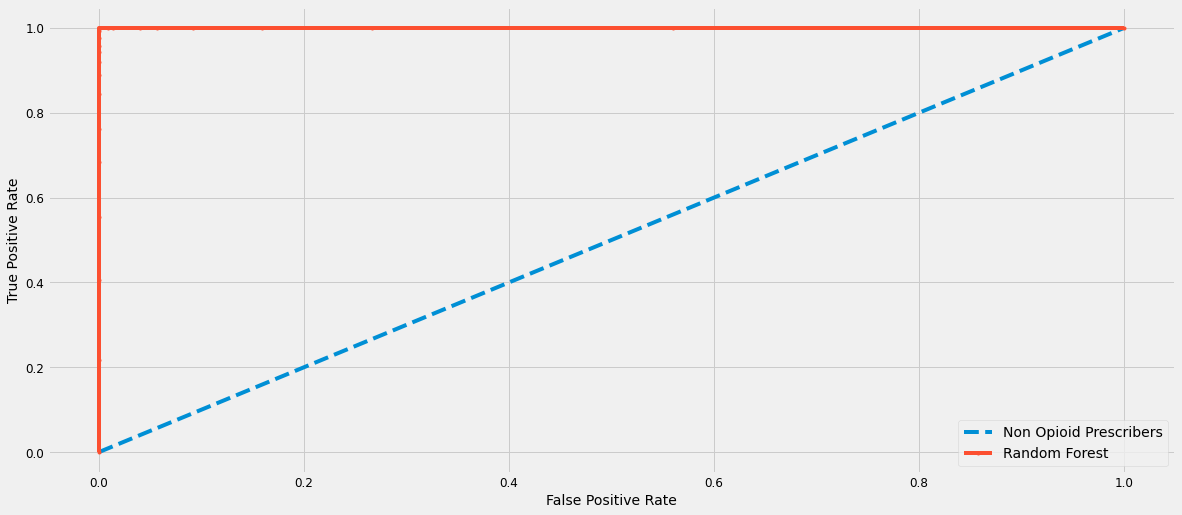

In [66]:
# generate a no opioid prescription prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = clf.predict_proba(X_test)

# keep probabilities for the positive outcome (opioid prescribed) only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Non Opioid Prescribers')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest')


# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [67]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.model_selection import train_test_split  
from sklearn.metrics import roc_curve

In [74]:
import sklearn.metrics as metrics

In [68]:
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [69]:
data_X, cls_lab = make_classification(n_samples=1100, n_classes=2, weights=[1,1], random_state=1)  
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=1)

In [71]:
model = RandomForestClassifier()
model.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

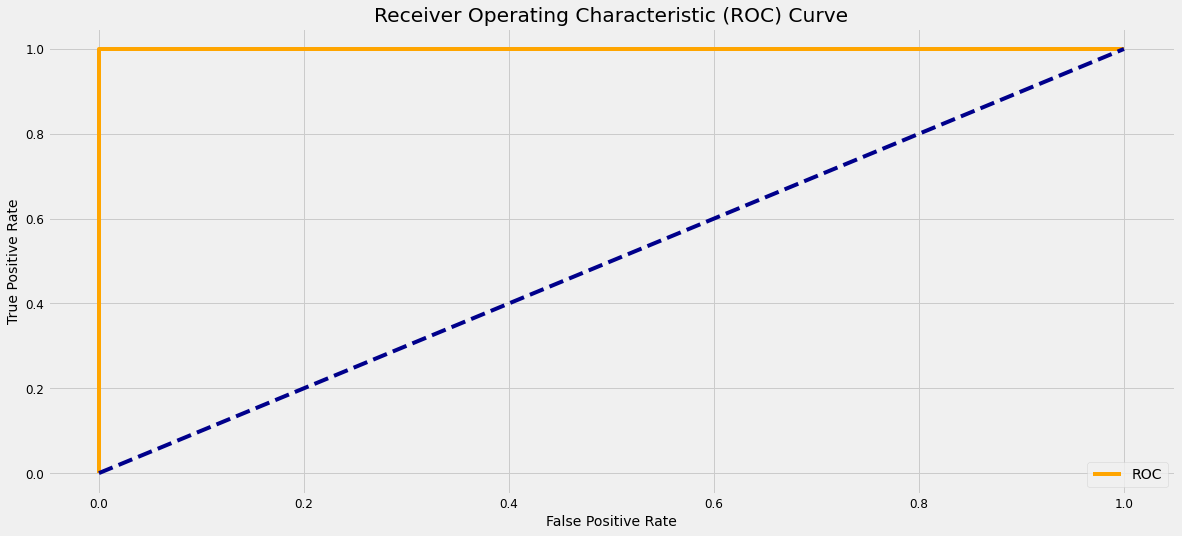

In [73]:
probs = model.predict_proba(test_X)
probs = probs[:, 1]
fper, tper, thresholds = roc_curve(test_y, probs)
plot_roc_cur(fper, tper)

In [100]:
import seaborn as seabornInstance

## XGBoost

In [328]:
pjme = pd.read_csv('df_clean.csv', index_col=[1], parse_dates=[0])

In [338]:
#pjme = pjme[['City', 'Rainfall(in)']]
pjme.drop('City', axis=1, inplace=True)
pjme

,Rainfall(in)
datetime,
2010-01-01,0.00
2010-01-02,0.00
2010-01-03,0.00
2010-01-04,0.00
2010-01-05,0.00
...,...
2019-12-27,0.00
2019-12-28,0.32
2019-12-29,0.07


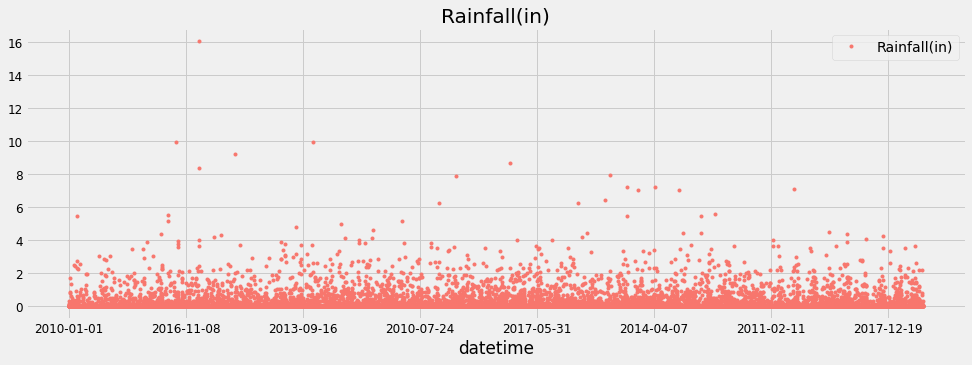

In [346]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='Rainfall(in)')

In [370]:
split_date = '2015-01-01'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

In [372]:
#pjme_train
print(pjme_train.shape)
print(pjme_test.shape)

(9118, 1)
(9125, 1)


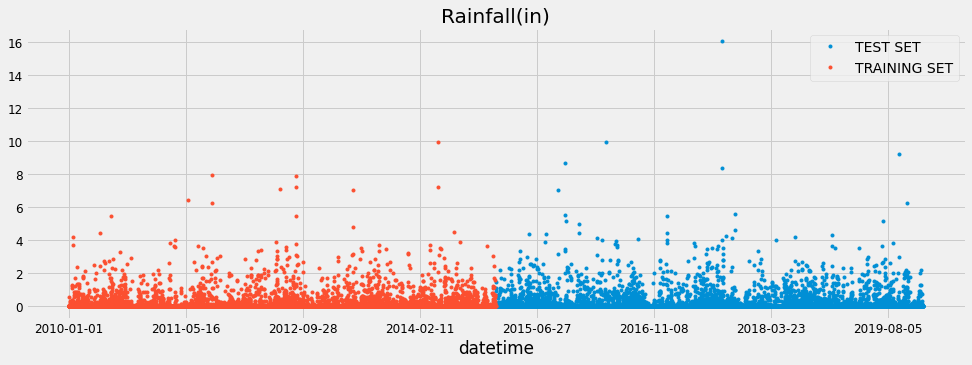

In [374]:
pjme_test \
    .rename(columns={'Rainfall(in)': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'Rainfall(in)': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='Rainfall(in)', style='.')
plt.show()

In [381]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='Rainfall(in)')

features_and_target = pd.concat([X, y], axis=1)

AttributeError: Can only use .dt accessor with datetimelike values

In [378]:
X_train, y_train = create_features(pjme_train, label='Rainfall(in)')
X_test, y_test = create_features(pjme_test, label='Rainfall(in)')

AttributeError: Can only use .dt accessor with datetimelike values

In [377]:
pjme_train['date'] = pd.to_datetime(pjme_train['date'])
df['datetime'] = pd.to_datetime(df['datetime'])

In [380]:
pjme_test

,Rainfall(in)
datetime,
2015-01-02,0.63
2015-01-03,0.63
2015-01-04,0.00
2015-01-05,0.00
2015-01-06,0.00
...,...
2019-12-27,0.00
2019-12-28,0.32
2019-12-29,0.07


In [356]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [324]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

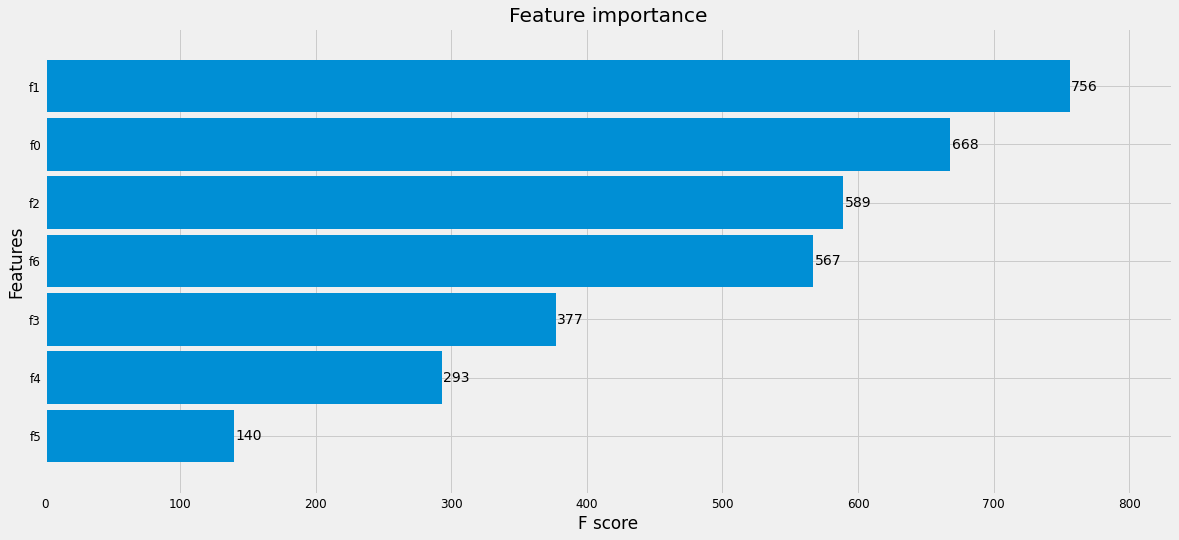

In [357]:
_ = plot_importance(reg, height=0.9)

In [361]:
#pjme_test['Rain_Prediction'] = reg.predict(X_test)
#pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

print(pjme_test.shape)
print(pjme_train.shape)

(9885, 1)
(8358, 2)


In [363]:
pjme_train.head(2)

,Rainfall(in),date
datetime,,
2010-01-01,0.0,2010-01-01
2010-01-02,0.0,2010-01-02


In [364]:
pjme_test.head(2)

,Rainfall(in)
datetime,
2014-08-02,0.0
2014-08-03,0.0


In [391]:
dfm['ma7'] = dfm['Rainfall(in)'].rolling(window=7).mean()
dfm['ma21'] = dfm['Rainfall(in)'].rolling(window=21).mean()

dfm['26_ema'] = dfm['Rainfall(in)'].ewm(span=26).mean().fillna(0)
dfm['12_ema'] = dfm['Rainfall(in)'].ewm(span=12).mean().fillna(0)
dfm['macd']= dfm['12_ema'] - dfm['26_ema']

window=21
no_of_std =2

rolling_mean= dfm['Rainfall(in)'].rolling(window).mean()
rolling_std= dfm['Rainfall(in)'].rolling(window).std()

dfm['Bollinger High'] = (rolling_mean + (rolling_std * no_of_std)).fillna(0)
dfm['Bollinger low'] = (rolling_mean - (rolling_std * no_of_std)).fillna(0)

dfm['ema'] = dfm['Rainfall(in)'].ewm(com=0.5).mean()

dfm['momentum'] = dfm['Rainfall(in)']-1

dfm.head()

,City,datetime,Dewpoint_temp(°F),Humidity(%),Sealevel_pressure(Hg),Max_temp(°F),Min_temp(°F),Average_temp(°F),Wind_speed(mph),Rainfall(in),ma7,ma21,26_ema,12_ema,macd,Bollinger High,Bollinger low,ema,momentum
0,Houston,2010-01-01,35.0,65.0,30.40,56.0,38.0,47.0,26.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
1,Houston,2010-01-02,32.0,66.0,30.33,56.0,31.0,44.0,15.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
2,Houston,2010-01-03,35.0,72.0,30.26,49.0,37.0,43.0,14.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
3,Houston,2010-01-04,29.0,62.0,30.41,48.0,34.0,41.0,25.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
4,Houston,2010-01-05,26.0,65.0,30.43,50.0,28.0,39.0,18.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,-1.0


In [392]:
dfm['pred_rain'] = np.where(dfm['Rainfall(in)'].shift(-1)>dfm['Rainfall(in)'],1,0)
dfm.head()

,City,datetime,Dewpoint_temp(°F),Humidity(%),Sealevel_pressure(Hg),Max_temp(°F),Min_temp(°F),Average_temp(°F),Wind_speed(mph),Rainfall(in),ma7,ma21,26_ema,12_ema,macd,Bollinger High,Bollinger low,ema,momentum,pred_rain
0,Houston,2010-01-01,35.0,65.0,30.40,56.0,38.0,47.0,26.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0
1,Houston,2010-01-02,32.0,66.0,30.33,56.0,31.0,44.0,15.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0
2,Houston,2010-01-03,35.0,72.0,30.26,49.0,37.0,43.0,14.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0
3,Houston,2010-01-04,29.0,62.0,30.41,48.0,34.0,41.0,25.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0
4,Houston,2010-01-05,26.0,65.0,30.43,50.0,28.0,39.0,18.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0


In [393]:
dfm = dfm.fillna(0)

In [405]:
dfm.drop(['City', 'datetime'], axis=1, inplace=True)

In [406]:
y = dfm['pred_rain']
X = dfm.drop('pred_rain', axis=1)

In [407]:
X_train, y_train, X_test, y_test = train_test_split(X,y, test_size=.3, random_state=101)
print('Observations: %d' %(len(X.index)))
print('X Training Observations: %d' % (len(X_train.index)))
print('X Testing Observations: %d' % (len(X_test.index)))
print('y Training Observations: %d' % (len(y_train)))
print('y Testing Observations: %d' % (len(y_test)))

Observations: 18243
X Training Observations: 12770
X Testing Observations: 12770
y Training Observations: 5473
y Testing Observations: 5473


In [408]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [409]:
X_train_scaled = scaler.fit_transform(X_train)
print(X_train_scaled)

[[8.42484748e-01 7.59493671e-01 5.25721872e-01 ... 9.71553503e-01
  8.05544668e-07 0.00000000e+00]
 [9.22351636e-01 7.21518987e-01 4.69963492e-01 ... 8.24310524e-01
  8.25704452e-02 8.55130785e-02]
 [7.75929007e-01 6.20253165e-01 1.99137073e-01 ... 8.76365587e-01
  7.70269922e-02 1.30784708e-02]
 ...
 [9.09040488e-01 5.94936709e-01 5.25721872e-01 ... 8.75947347e-01
  1.04280047e-02 0.00000000e+00]
 [8.82418192e-01 6.83544304e-01 5.33687355e-01 ... 9.81284496e-01
  9.71259474e-04 0.00000000e+00]
 [3.63283417e-01 6.07594937e-01 7.56720876e-01 ... 8.67484748e-01
  1.92160005e-03 0.00000000e+00]]


In [416]:
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree = 0.3, learning_rate=0.1, max_depth= 5, alpha=10, n_estimators=100)

xg_reg.fit(X_train_scaled, y_train)

ValueError: DataFrame for label cannot have multiple columns

In [412]:
dfm

,Dewpoint_temp(°F),Humidity(%),Sealevel_pressure(Hg),Max_temp(°F),Min_temp(°F),Average_temp(°F),Wind_speed(mph),Rainfall(in),ma7,ma21,26_ema,12_ema,macd,Bollinger High,Bollinger low,ema,momentum,pred_rain
0,35.0,65.0,30.40,56.0,38.0,47.0,26.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.00,0
1,32.0,66.0,30.33,56.0,31.0,44.0,15.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.00,0
2,35.0,72.0,30.26,49.0,37.0,43.0,14.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.00,0
3,29.0,62.0,30.41,48.0,34.0,41.0,25.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.00,0
4,26.0,65.0,30.43,50.0,28.0,39.0,18.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18238,65.0,78.0,30.10,77.0,67.0,72.0,23.0,0.00,0.448571,0.192381,0.200858,0.258035,0.057177,1.203458,-0.818696,0.020218,-1.00,1
18239,67.0,80.0,30.05,80.0,69.0,75.0,21.0,0.32,0.470000,0.207619,0.209683,0.267568,0.057885,1.216161,-0.800923,0.220073,-0.68,0
18240,69.0,83.0,30.00,81.0,72.0,77.0,20.0,0.07,0.365714,0.210952,0.199337,0.237173,0.037837,1.217072,-0.795167,0.120024,-0.93,0
18241,68.0,83.0,29.97,77.0,70.0,74.0,22.0,0.00,0.055714,0.210952,0.184571,0.200685,0.016114,1.217072,-0.795167,0.040008,-1.00,0


In [660]:
df = df.set_index('datetime')

## Linear Regression

In [458]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

n_features = 5

logreg = LogisticRegression(solver='lbfgs')
selector = RFE(logreg, n_features, step=1)
selector = selector.fit(X_train, y_train)

rank = selector.ranking_
select_results = pd.DataFrame({'feature': features,
                               'rank': rank}).sort_values('rank').reset_index().drop('index', axis=1).head(10)

ValueError: Unknown label type: 'continuous'

In [457]:
# standardize the features
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [436]:
#for tuning parameters
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, RandomizedSearchCV

In [441]:
rms = sqrt(mean_squared_error(y_test, y_pred))
print ('RMSE:', rms)

RMSE: 0.4428883405103687


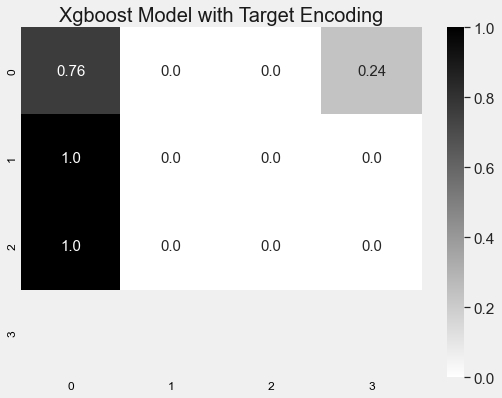

In [442]:
def flag_feature(x):
    if x >=0 and x < 7:
        return 0
    elif x >= 7 and x < 14:
        return 1
    elif x >= 14 and x < 21:
        return 2
    elif x >= 21 and x < 28:
        return 3
    elif x >= 28 and x < 35:
        return 4
    else:
        return 5
obs_pre = pd.DataFrame(zip(y_test, y_pred))
cols = ['Real', 'Predict']
obs_pre.columns = cols
obs_pre['Real_flag'] = obs_pre['Real'].apply(flag_feature)
obs_pre['Predict_flag'] = obs_pre['Predict'].apply(flag_feature)
conf = confusion_matrix(obs_pre['Real_flag'], obs_pre['Predict_flag'])
conf_norm = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
conf_norm_round = np.around(conf_norm, decimals=2)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
sns.set(font_scale=1.4, color_codes = 'w')
ax = sns.heatmap(conf_norm, cmap="binary", annot = conf_norm_round, annot_kws={"size": 15}, fmt = '', vmin=0, vmax=1)
ax.set_title('Xgboost Model with Target Encoding', fontsize=20)
plt.show()

In [578]:
df2 = pd.read_csv('df_clean.csv')


In [579]:
df2['datetime'] = pd.to_datetime(df2['datetime'])
df2['Day'] = df2['datetime'].dt.day
df2['Week'] = df2['datetime'].dt.week
df2['Month'] = df2['datetime'].dt.month
df2['Year'] = df2['datetime'].dt.year

In [580]:
df2.drop('City', axis=1, inplace=True)

In [581]:
df2.set_index('datetime', inplace=True)

In [582]:
df2.dtypes

Dewpoint_temp(°F)        float64
Humidity(%)              float64
Sealevel_pressure(Hg)    float64
Max_temp(°F)             float64
Min_temp(°F)             float64
Average_temp(°F)         float64
Wind_speed(mph)          float64
Rainfall(in)             float64
Day                        int64
Week                       int64
Month                      int64
Year                       int64
dtype: object

In [583]:
X1 = df2.drop('Rainfall(in)', axis=1)
y2 = df2['Rainfall(in)']

X_train, X_test, y_train, y_test = train_test_split(X1,y2, test_size=0.30, random_state=0)

In [588]:
# Normalizing continuous variables
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [586]:
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)

sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

clf = LogisticRegression()
model_res = clf.fit(X_train_res, y_train_res)

ValueError: Unknown label type: 'continuous'

In [590]:
df3 = df2.copy()
df3['Rain or Not'] = np.where(df3['Rainfall(in)'] > 0, 1, 0)

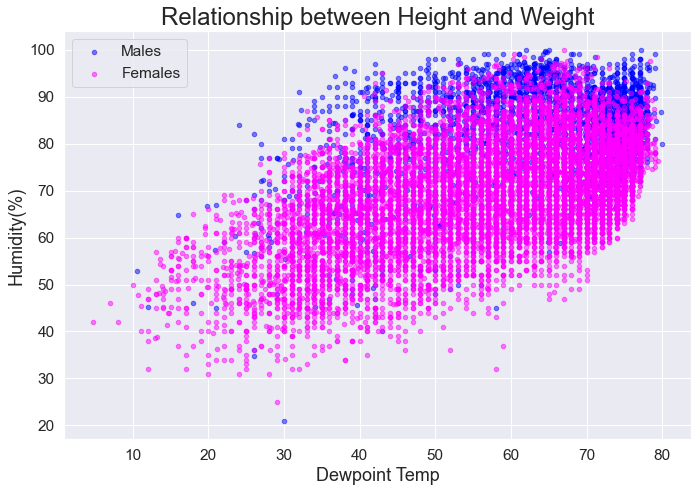

In [597]:
ax1 = df3[df3['Rain or Not'] == 1].plot(kind='scatter', x='Dewpoint_temp(°F)', y='Humidity(%)', color='blue', alpha=0.5, figsize=(10, 7))
df3[df3['Rain or Not'] == 0].plot(kind='scatter', x='Dewpoint_temp(°F)', y='Humidity(%)', color='magenta', alpha=0.5, figsize=(10 ,7), ax=ax1)
plt.legend(labels=['Males', 'Females'])
plt.title('Relationship between Height and Weight', size=24)
plt.xlabel('Dewpoint Temp', size=18)
plt.ylabel('Humidity(%)', size=18);

In [598]:
df3_rain = df3[df3['Rain or Not'] == 1]
df3_no_rain = df3[df3['Rain or Not'] == 0]

# polynomial - males
rain_fit = np.polyfit(df3_rain['Dewpoint_temp(°F)'], df3_rain['Humidity(%)'] , 1)


# polynomial - females
no_rain_fit = np.polyfit(df3_no_rain['Dewpoint_temp(°F)'], df3_no_rain['Humidity(%)'], 1)


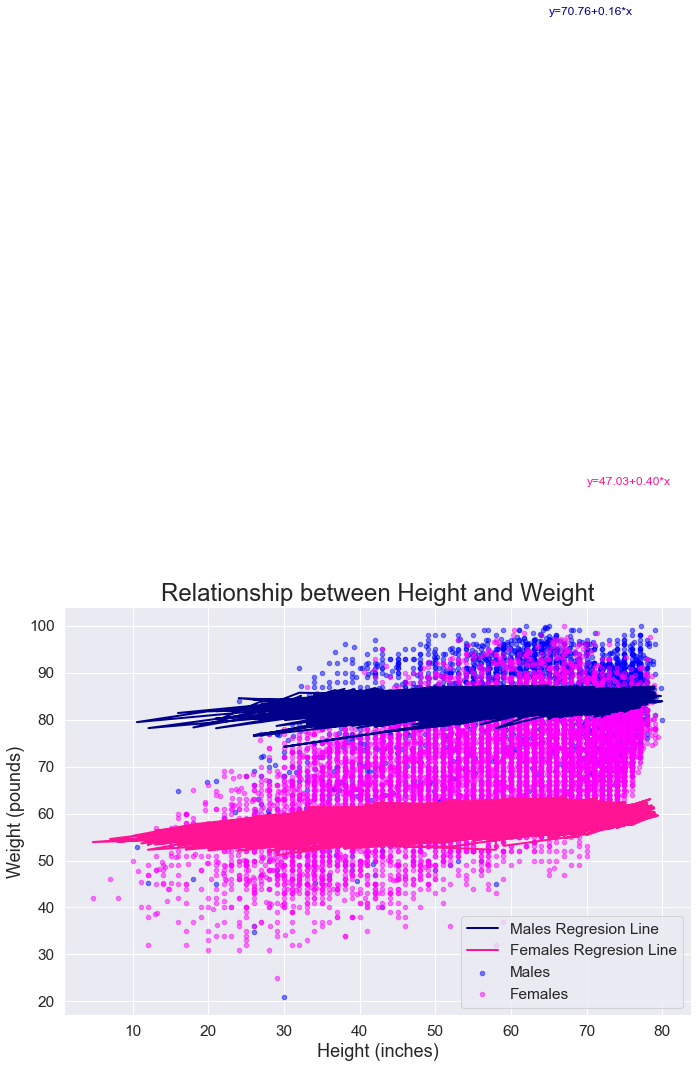

In [599]:

# Scatter plots.
ax1 = df3_rain.plot(kind='scatter', x='Dewpoint_temp(°F)', y='Humidity(%)', color='blue', alpha=0.5, figsize=(10, 7))
df3_no_rain.plot(kind='scatter', x='Dewpoint_temp(°F)', y='Humidity(%)', color='magenta', alpha=0.5, figsize=(10, 7), ax=ax1)

# regression lines
plt.plot(df3_rain['Dewpoint_temp(°F)'], rain_fit[0] * df3_rain['Humidity(%)'] + rain_fit[1], color='darkblue', linewidth=2)
plt.plot(df3_no_rain['Dewpoint_temp(°F)'], rain_fit[0] * df3_no_rain['Humidity(%)'] + no_rain_fit[1], color='deeppink', linewidth=2)

# regression equations
plt.text(65, 230, 'y={:.2f}+{:.2f}*x'.format(rain_fit[1], rain_fit[0]), color='darkblue', size=12)
plt.text(70, 130, 'y={:.2f}+{:.2f}*x'.format(no_rain_fit[1], no_rain_fit[0]), color='deeppink', size=12)

# legend, title and labels.
plt.legend(labels=['Males Regresion Line', 'Females Regresion Line', 'Males', 'Females'])
plt.title('Relationship between Height and Weight', size=24)
plt.xlabel('Height (inches)', size=18)
plt.ylabel('Weight (pounds)', size=18);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015A926C4948>,
      dtype=object)

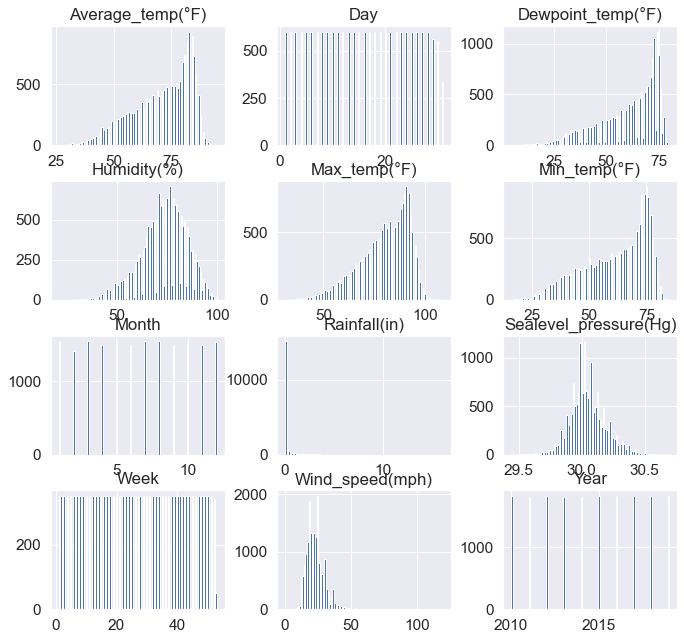

In [611]:
num_cols_df = df3.select_dtypes(['int64','float64','datetime64[ns, UTC]'])
cat_cols_df = df3.select_dtypes(['object'])
num_cols_df.hist(figsize = (10,10),bins=100)

In [617]:
from sklearn.model_selection import train_test_split

X = df3.drop('Rainfall(in)', axis = 1)
y = df3['Rainfall(in)']
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

In [618]:
lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [619]:
from sklearn.metrics import mean_squared_error
y_test_preds = lm_model.predict(X_test)
mse_score = mean_squared_error(y_test, y_test_preds)
length_y_test = len(y_test)
print("The MSE for your model was {} on {} values.".format(mse_score, length_y_test))

The MSE for your model was 0.2112857021881453 on 5473 values.


In [632]:
df= pd.read_csv('df_clean.csv')

In [633]:
df = df.drop('City', axis=1)

In [638]:
y

,datetime,Dewpoint_temp(°F),Humidity(%),Sealevel_pressure(Hg),Max_temp(°F),Min_temp(°F),Average_temp(°F),Wind_speed(mph)
0,2010-01-01,35.0,65.0,30.40,56.0,38.0,47.0,26.0
1,2010-01-02,32.0,66.0,30.33,56.0,31.0,44.0,15.0
2,2010-01-03,35.0,72.0,30.26,49.0,37.0,43.0,14.0
3,2010-01-04,29.0,62.0,30.41,48.0,34.0,41.0,25.0
4,2010-01-05,26.0,65.0,30.43,50.0,28.0,39.0,18.0
...,...,...,...,...,...,...,...,...
18238,2019-12-27,65.0,78.0,30.10,77.0,67.0,72.0,23.0
18239,2019-12-28,67.0,80.0,30.05,80.0,69.0,75.0,21.0
18240,2019-12-29,69.0,83.0,30.00,81.0,72.0,77.0,20.0
18241,2019-12-30,68.0,83.0,29.97,77.0,70.0,74.0,22.0
